In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [2]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [3]:
true_theta = np.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_datasets = 200
n_samples = 500

In [4]:
actual_data = simulate_gandk(true_theta, n_samples)
actual_data

array([[ 6.24811577],
       [ 3.5513141 ],
       [ 2.41642712],
       [ 6.42523021],
       [ 6.95124093],
       [ 2.23241121],
       [14.60922546],
       [ 2.886569  ],
       [11.8032684 ],
       [ 2.50496362],
       [ 2.79126897],
       [ 2.89909212],
       [ 5.95591479],
       [ 2.62958231],
       [ 2.8786011 ],
       [ 2.5478605 ],
       [ 4.05493728],
       [ 3.57248123],
       [ 3.12108251],
       [ 8.49142739],
       [ 3.29761437],
       [ 4.72350917],
       [ 3.05392872],
       [ 2.59439013],
       [ 4.92617295],
       [ 2.30630739],
       [ 3.77109219],
       [ 3.99876135],
       [ 2.25243633],
       [ 2.60677541],
       [ 3.02366557],
       [ 3.13216737],
       [ 4.55953673],
       [ 2.33768662],
       [ 2.72524093],
       [ 6.08625475],
       [ 2.31429478],
       [ 2.52651245],
       [ 4.60579729],
       [ 3.10953935],
       [ 4.06274145],
       [ 2.32737414],
       [ 2.52348526],
       [ 2.37484341],
       [ 3.99752702],
       [14

In [5]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([3.05373649, 1.7887773 , 0.47458489, 1.77353099])

In [6]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [7]:
actual_summary_statistics = np.array([2.96978227, 1.45609898, 0.4837584 , 2.00723605])

## Training Wasserstein Gaussianing

In [8]:
wass_num_datasets = 6000
wass_n_samples = 30
maxG = 4

In [9]:
wass_n_summary_statistics = np.zeros((wass_num_datasets, num_latent))
for i in range(0, wass_num_datasets):
    y = simulate_gandk(true_theta, wass_n_samples)
    wass_n_summary_statistics[i,:] = compute_summary_statistics(y)

In [10]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [11]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in range(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = int(np.argmin(bic_values) + 1)
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    mean_mixture_obj = best_mixture_obj.means_
    sigma_mixture_obj = best_mixture_obj.covariances_
    weights_mixture_obj = best_mixture_obj.weights_
    return best_mixture_obj, bestG, np.array(mean_mixture_obj), np.array(sigma_mixture_obj), np.array(weights_mixture_obj)

In [12]:
def grad_log_density_mixture(data, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj):
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,len(actual_summary_statistics))) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [13]:
# Start training

# Hyperparams
patience_max = 5
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = []
bestG_seq = []
lb = []
LB_Smoothed = []

# At current particles, fit mixture normal
mixture_model = mixture_model_fit(original_train_summary_statistics, maxG)
mixture_obj_seq.append(mixture_model[0])
bestG_seq.append(mixture_model[1])

In [14]:
for t in tqdm(range(stop)):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_model = mixture_model_fit(wass_train_summary_statistics, maxG)
    mixture_obj = mixture_model[0]
    bestG = mixture_model[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq.append(mixture_obj)
    bestG_seq.append(bestG)

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

  0%|          | 1/5000 [00:01<1:39:16,  1.19s/it]

LB -7.223808259583641


  0%|          | 2/5000 [00:02<1:24:12,  1.01s/it]

LB -5.940037677834486


  0%|          | 3/5000 [00:03<1:22:58,  1.00it/s]

LB -5.476762768767345


  0%|          | 4/5000 [00:03<1:20:25,  1.04it/s]

LB -5.1276345950691535


  0%|          | 5/5000 [00:04<1:18:59,  1.05it/s]

LB -4.796597216373388


  0%|          | 6/5000 [00:05<1:14:05,  1.12it/s]

LB -4.482698667139356


  0%|          | 7/5000 [00:06<1:09:15,  1.20it/s]

LB -4.225096888216561


  0%|          | 8/5000 [00:07<1:07:20,  1.24it/s]

LB -4.006190605638866


  0%|          | 9/5000 [00:07<1:06:19,  1.25it/s]

LB -3.8186603235393797


  0%|          | 10/5000 [00:08<58:54,  1.41it/s] 

LB -3.5591612042473177


  0%|          | 11/5000 [00:09<1:00:28,  1.37it/s]

LB -3.3626944874763693


  0%|          | 12/5000 [00:09<1:02:12,  1.34it/s]

LB -3.1759015123672474


  0%|          | 13/5000 [00:10<1:05:32,  1.27it/s]

LB -2.998497849001079


  0%|          | 14/5000 [00:11<1:05:50,  1.26it/s]

LB -2.8284227781302262


  0%|          | 15/5000 [00:12<1:07:49,  1.22it/s]

LB -2.6658952702412457


  0%|          | 16/5000 [00:13<1:08:29,  1.21it/s]

LB -2.509809279462675


  0%|          | 17/5000 [00:14<1:08:58,  1.20it/s]

LB -2.359190477050085


  0%|          | 18/5000 [00:15<1:15:10,  1.10it/s]

LB -2.2145148888590365


  0%|          | 19/5000 [00:16<1:16:42,  1.08it/s]

LB -2.0770474532739747


  0%|          | 20/5000 [00:17<1:16:19,  1.09it/s]

LB -1.9560012142401138


  0%|          | 21/5000 [00:18<1:16:18,  1.09it/s]

LB Smoothed -3.5568850082593637


  0%|          | 22/5000 [00:19<1:16:37,  1.08it/s]

LB Smoothed -3.339427395030066


  0%|          | 23/5000 [00:19<1:14:39,  1.11it/s]

LB Smoothed -3.141584552415995


  0%|          | 24/5000 [00:20<1:12:44,  1.14it/s]

LB Smoothed -2.954279165699121


  0%|          | 25/5000 [00:21<1:06:34,  1.25it/s]

LB Smoothed -2.776112055804383


  1%|          | 26/5000 [00:21<1:01:07,  1.36it/s]

LB Smoothed -2.608468441065555


  1%|          | 27/5000 [00:22<56:47,  1.46it/s]  

LB Smoothed -2.4485535811821872


  1%|          | 28/5000 [00:23<56:56,  1.46it/s]

LB Smoothed -2.294491411365185


  1%|          | 29/5000 [00:23<55:30,  1.49it/s]

LB Smoothed -2.1447840382920487


  1%|          | 30/5000 [00:24<53:54,  1.54it/s]

LB Smoothed -2.0033662672028076


  1%|          | 31/5000 [00:24<52:15,  1.58it/s]

LB Smoothed -1.8670615656066714


  1%|          | 32/5000 [00:25<51:43,  1.60it/s]

LB Smoothed -1.735496179102823


  1%|          | 33/5000 [00:26<54:55,  1.51it/s]

LB Smoothed -1.610251038732301


  1%|          | 34/5000 [00:27<57:51,  1.43it/s]

LB Smoothed -1.4871834117312035


  1%|          | 35/5000 [00:27<57:45,  1.43it/s]

LB Smoothed -1.367954225381856


  1%|          | 36/5000 [00:28<57:11,  1.45it/s]

LB Smoothed -1.2523410545429596


  1%|          | 37/5000 [00:29<1:00:39,  1.36it/s]

LB Smoothed -1.140168757572597


  1%|          | 38/5000 [00:29<57:42,  1.43it/s]  

LB Smoothed -1.0312333707542731


  1%|          | 39/5000 [00:30<57:34,  1.44it/s]

LB Smoothed -0.9252607947831132


  1%|          | 40/5000 [00:31<1:00:25,  1.37it/s]

LB Smoothed -0.8214886634207896


  1%|          | 41/5000 [00:32<1:02:30,  1.32it/s]

LB Smoothed -0.7229534864855328


  1%|          | 42/5000 [00:33<1:05:00,  1.27it/s]

LB Smoothed -0.6236666418339704


  1%|          | 43/5000 [00:34<1:06:59,  1.23it/s]

LB Smoothed -0.5283343026369588


  1%|          | 44/5000 [00:35<1:11:33,  1.15it/s]

LB Smoothed -0.4374935340010044


  1%|          | 45/5000 [00:35<1:07:03,  1.23it/s]

LB Smoothed -0.34894447898232983


  1%|          | 46/5000 [00:36<1:03:20,  1.30it/s]

LB Smoothed -0.2637556905163712


  1%|          | 47/5000 [00:36<58:18,  1.42it/s]  

LB Smoothed -0.1795566218364757


  1%|          | 48/5000 [00:37<55:18,  1.49it/s]

LB Smoothed -0.09741445779472939


  1%|          | 49/5000 [00:38<53:29,  1.54it/s]

LB Smoothed -0.017260206716955


  1%|          | 50/5000 [00:38<48:31,  1.70it/s]

LB Smoothed 0.060971233655341184


  1%|          | 51/5000 [00:39<49:49,  1.66it/s]

LB Smoothed 0.13734143036647525


  1%|          | 52/5000 [00:39<50:31,  1.63it/s]

LB Smoothed 0.21385362556651702


  1%|          | 53/5000 [00:40<1:04:04,  1.29it/s]

LB Smoothed 0.28668082534530653


  1%|          | 54/5000 [00:41<1:03:53,  1.29it/s]

LB Smoothed 0.357813038460427


  1%|          | 55/5000 [00:42<1:05:15,  1.26it/s]

LB Smoothed 0.4256243751915183


  1%|          | 56/5000 [00:43<1:05:39,  1.26it/s]

LB Smoothed 0.4935152418893443


  1%|          | 57/5000 [00:44<1:06:44,  1.23it/s]

LB Smoothed 0.5598549963173642


  1%|          | 58/5000 [00:44<1:03:39,  1.29it/s]

LB Smoothed 0.6246874104515578


  1%|          | 59/5000 [00:45<1:08:03,  1.21it/s]

LB Smoothed 0.6880544127425212


  1%|          | 60/5000 [00:46<1:13:04,  1.13it/s]

LB Smoothed 0.7515333819851118


  1%|          | 61/5000 [00:47<1:16:05,  1.08it/s]

LB Smoothed 0.8110832758945513


  1%|          | 62/5000 [00:48<1:09:36,  1.18it/s]

LB Smoothed 0.8702736236921039


  1%|▏         | 63/5000 [00:49<1:12:07,  1.14it/s]

LB Smoothed 0.9281502897588766


  1%|▏         | 64/5000 [00:50<1:11:51,  1.14it/s]

LB Smoothed 0.9847476314949002


  1%|▏         | 65/5000 [00:51<1:10:37,  1.16it/s]

LB Smoothed 1.0403188580506493


  1%|▏         | 66/5000 [00:51<1:08:22,  1.20it/s]

LB Smoothed 1.094458829491851


  1%|▏         | 67/5000 [00:53<1:21:20,  1.01it/s]

LB Smoothed 1.1474153056420524


  1%|▏         | 68/5000 [00:54<1:29:22,  1.09s/it]

LB Smoothed 1.1992180440371891


  1%|▏         | 69/5000 [00:56<1:39:20,  1.21s/it]

LB Smoothed 1.2498958027605114


  1%|▏         | 70/5000 [00:57<1:39:04,  1.21s/it]

LB Smoothed 1.299476391414746


  1%|▏         | 71/5000 [00:58<1:33:26,  1.14s/it]

LB Smoothed 1.3464710693780026


  1%|▏         | 72/5000 [00:59<1:32:43,  1.13s/it]

LB Smoothed 1.3939326113947923


  1%|▏         | 73/5000 [01:00<1:37:29,  1.19s/it]

LB Smoothed 1.4403752517524266


  1%|▏         | 74/5000 [01:02<1:39:40,  1.21s/it]

LB Smoothed 1.4874995293052256


  2%|▏         | 75/5000 [01:03<1:37:59,  1.19s/it]

LB Smoothed 1.5319766377369113


  2%|▏         | 76/5000 [01:04<1:38:16,  1.20s/it]

LB Smoothed 1.5755059739296282


  2%|▏         | 77/5000 [01:05<1:35:40,  1.17s/it]

LB Smoothed 1.618109859085745


  2%|▏         | 78/5000 [01:06<1:39:09,  1.21s/it]

LB Smoothed 1.6598099630357004


  2%|▏         | 79/5000 [01:08<1:45:47,  1.29s/it]

LB Smoothed 1.700627331299449


  2%|▏         | 80/5000 [01:09<1:48:35,  1.32s/it]

LB Smoothed 1.7415811221255184


  2%|▏         | 81/5000 [01:10<1:45:26,  1.29s/it]

LB Smoothed 1.7807025709026827


  2%|▏         | 82/5000 [01:12<2:01:29,  1.48s/it]

LB Smoothed 1.8177961369648372


  2%|▏         | 83/5000 [01:14<2:14:47,  1.64s/it]

LB Smoothed 1.8552935715884395


  2%|▏         | 84/5000 [01:17<2:33:22,  1.87s/it]

LB Smoothed 1.892936644330689


  2%|▏         | 85/5000 [01:19<2:36:00,  1.90s/it]

LB Smoothed 1.92888771167624


  2%|▏         | 86/5000 [01:20<2:28:29,  1.81s/it]

LB Smoothed 1.963559454181252


  2%|▏         | 87/5000 [01:21<2:09:15,  1.58s/it]

LB Smoothed 1.9980184162749748


  2%|▏         | 88/5000 [01:23<1:59:36,  1.46s/it]

LB Smoothed 2.0317595506169193


  2%|▏         | 89/5000 [01:24<1:50:31,  1.35s/it]

LB Smoothed 2.064798844467375


  2%|▏         | 90/5000 [01:25<1:44:28,  1.28s/it]

LB Smoothed 2.0986675225969633


  2%|▏         | 91/5000 [01:26<1:38:15,  1.20s/it]

LB Smoothed 2.1303540392802005


  2%|▏         | 92/5000 [01:27<1:36:25,  1.18s/it]

LB Smoothed 2.1613841879378564


  2%|▏         | 93/5000 [01:28<1:34:06,  1.15s/it]

LB Smoothed 2.191772392541216


  2%|▏         | 94/5000 [01:29<1:25:12,  1.04s/it]

LB Smoothed 2.22153271707344


  2%|▏         | 95/5000 [01:30<1:30:45,  1.11s/it]

LB Smoothed 2.2506788769651136


  2%|▏         | 96/5000 [01:31<1:31:07,  1.11s/it]

LB Smoothed 2.279224250021438


  2%|▏         | 97/5000 [01:32<1:29:11,  1.09s/it]

LB Smoothed 2.306460005062015


  2%|▏         | 98/5000 [01:33<1:26:38,  1.06s/it]

LB Smoothed 2.333842972112518


  2%|▏         | 99/5000 [01:34<1:25:40,  1.05s/it]

LB Smoothed 2.3606633350934128


  2%|▏         | 100/5000 [01:35<1:18:40,  1.04it/s]

LB Smoothed 2.386933222615959


  2%|▏         | 101/5000 [01:36<1:18:39,  1.04it/s]

LB Smoothed 2.4138691552265183


  2%|▏         | 102/5000 [01:37<1:22:44,  1.01s/it]

LB Smoothed 2.4390697283671146


  2%|▏         | 103/5000 [01:38<1:19:50,  1.02it/s]

LB Smoothed 2.4637545398722636


  2%|▏         | 104/5000 [01:39<1:15:51,  1.08it/s]

LB Smoothed 2.4879346088889513


  2%|▏         | 105/5000 [01:40<1:17:59,  1.05it/s]

LB Smoothed 2.51214885292253


  2%|▏         | 106/5000 [01:41<1:22:19,  1.01s/it]

LB Smoothed 2.5353580934828623


  2%|▏         | 107/5000 [01:42<1:24:07,  1.03s/it]

LB Smoothed 2.5569206582751036


  2%|▏         | 108/5000 [01:43<1:23:09,  1.02s/it]

LB Smoothed 2.579190183091048


  2%|▏         | 109/5000 [01:44<1:18:51,  1.03it/s]

LB Smoothed 2.6010062320019274


  2%|▏         | 110/5000 [01:45<1:20:48,  1.01it/s]

LB Smoothed 2.6223783833347425


  2%|▏         | 111/5000 [01:46<1:21:34,  1.00s/it]

LB Smoothed 2.643315997117776


  2%|▏         | 112/5000 [01:47<1:24:45,  1.04s/it]

LB Smoothed 2.6638282208792985


  2%|▏         | 113/5000 [01:48<1:24:31,  1.04s/it]

LB Smoothed 2.6839239952474356


  2%|▏         | 114/5000 [01:49<1:24:41,  1.04s/it]

LB Smoothed 2.703612059360474


  2%|▏         | 115/5000 [01:50<1:25:03,  1.04s/it]

LB Smoothed 2.7229009560963053


  2%|▏         | 116/5000 [01:51<1:30:31,  1.11s/it]

LB Smoothed 2.742520918939262


  2%|▏         | 117/5000 [01:53<1:33:50,  1.15s/it]

LB Smoothed 2.761036016681363


  2%|▏         | 118/5000 [01:54<1:37:06,  1.19s/it]

LB Smoothed 2.778422775411682


  2%|▏         | 119/5000 [01:55<1:39:47,  1.23s/it]

LB Smoothed 2.7961977685558903


  2%|▏         | 120/5000 [01:56<1:35:40,  1.18s/it]

LB Smoothed 2.8125476757149155


  2%|▏         | 121/5000 [01:57<1:29:47,  1.10s/it]

LB Smoothed 2.8296072297940817


  2%|▏         | 122/5000 [01:58<1:20:50,  1.01it/s]

LB Smoothed 2.846322354134662


  2%|▏         | 123/5000 [01:59<1:15:13,  1.08it/s]

LB Smoothed 2.8627001908559726


  2%|▏         | 124/5000 [01:59<1:09:40,  1.17it/s]

LB Smoothed 2.878747725917172


  2%|▎         | 125/5000 [02:00<1:06:57,  1.21it/s]

LB Smoothed 2.894471792920603


  3%|▎         | 126/5000 [02:01<1:07:05,  1.21it/s]

LB Smoothed 2.9098818980767156


  3%|▎         | 127/5000 [02:02<1:04:51,  1.25it/s]

LB Smoothed 2.9249825840314596


  3%|▎         | 128/5000 [02:03<1:04:45,  1.25it/s]

LB Smoothed 2.939779455418559


  3%|▎         | 129/5000 [02:04<1:09:39,  1.17it/s]

LB Smoothed 2.954278770145759


  3%|▎         | 130/5000 [02:04<1:10:41,  1.15it/s]

LB Smoothed 2.968486651254621


  3%|▎         | 131/5000 [02:05<1:09:15,  1.17it/s]

LB Smoothed 2.9810468805656294


  3%|▎         | 132/5000 [02:06<1:06:13,  1.23it/s]

LB Smoothed 2.994688273870595


  3%|▎         | 133/5000 [02:07<1:04:15,  1.26it/s]

LB Smoothed 3.0080558608784544


  3%|▎         | 134/5000 [02:08<1:06:11,  1.23it/s]

LB Smoothed 3.0211552555625665


  3%|▎         | 135/5000 [02:09<1:10:05,  1.16it/s]

LB Smoothed 3.03399195210199


  3%|▎         | 136/5000 [02:10<1:13:19,  1.11it/s]

LB Smoothed 3.0465713276525235


  3%|▎         | 137/5000 [02:10<1:10:39,  1.15it/s]

LB Smoothed 3.0596523446779855


  3%|▎         | 138/5000 [02:12<1:16:47,  1.06it/s]

LB Smoothed 3.071731386503313


  3%|▎         | 139/5000 [02:13<1:18:36,  1.03it/s]

LB Smoothed 3.084634448624163


  3%|▎         | 140/5000 [02:14<1:21:56,  1.01s/it]

LB Smoothed 3.0962391983632425


  3%|▎         | 141/5000 [02:15<1:25:25,  1.05s/it]

LB Smoothed 3.107611844326652


  3%|▎         | 142/5000 [02:16<1:24:58,  1.05s/it]

LB Smoothed 3.1187571144596533


  3%|▎         | 143/5000 [02:17<1:27:56,  1.09s/it]

LB Smoothed 3.1296796371999003


  3%|▎         | 144/5000 [02:18<1:29:21,  1.10s/it]

LB Smoothed 3.14038394371307


  3%|▎         | 145/5000 [02:19<1:28:47,  1.10s/it]

LB Smoothed 3.1520450495212997


  3%|▎         | 146/5000 [02:20<1:30:51,  1.12s/it]

LB Smoothed 3.162325690110823


  3%|▎         | 147/5000 [02:22<1:30:09,  1.11s/it]

LB Smoothed 3.1724011477427436


  3%|▎         | 148/5000 [02:22<1:25:42,  1.06s/it]

LB Smoothed 3.1809676231243826


  3%|▎         | 149/5000 [02:23<1:22:25,  1.02s/it]

LB Smoothed 3.190643340508652


  3%|▎         | 150/5000 [02:24<1:19:01,  1.02it/s]

LB Smoothed 3.201488355429735


  3%|▎         | 151/5000 [02:25<1:16:27,  1.06it/s]

LB Smoothed 3.210783622507382


  3%|▎         | 152/5000 [02:26<1:15:30,  1.07it/s]

LB Smoothed 3.2198936755808045


  3%|▎         | 153/5000 [02:27<1:15:59,  1.06it/s]

LB Smoothed 3.228822262071185


  3%|▎         | 154/5000 [02:28<1:16:31,  1.06it/s]

LB Smoothed 3.2375730516269074


  3%|▎         | 155/5000 [02:29<1:20:14,  1.01it/s]

LB Smoothed 3.2461496378197574


  3%|▎         | 156/5000 [02:30<1:23:07,  1.03s/it]

LB Smoothed 3.2545555398003585


  3%|▎         | 157/5000 [02:31<1:17:37,  1.04it/s]

LB Smoothed 3.2627942039140168


  3%|▎         | 158/5000 [02:32<1:15:01,  1.08it/s]

LB Smoothed 3.270869005278074


  3%|▎         | 159/5000 [02:33<1:14:40,  1.08it/s]

LB Smoothed 3.278783249321865


  3%|▎         | 160/5000 [02:34<1:15:08,  1.07it/s]

LB Smoothed 3.2865401732903075


  3%|▎         | 161/5000 [02:34<1:11:38,  1.13it/s]

LB Smoothed 3.29414294771213


  3%|▎         | 162/5000 [02:36<1:14:42,  1.08it/s]

LB Smoothed 3.3015946778337133


  3%|▎         | 163/5000 [02:36<1:11:50,  1.12it/s]

LB Smoothed 3.3088984050194736


  3%|▎         | 164/5000 [02:37<1:08:59,  1.17it/s]

LB Smoothed 3.316057108119696


  3%|▎         | 165/5000 [02:38<1:07:50,  1.19it/s]

LB Smoothed 3.3230737048066907


  3%|▎         | 166/5000 [02:39<1:10:21,  1.15it/s]

LB Smoothed 3.3299510528801206


  3%|▎         | 167/5000 [02:40<1:08:19,  1.18it/s]

LB Smoothed 3.3379999142286474


  3%|▎         | 168/5000 [02:40<1:07:23,  1.19it/s]

LB Smoothed 3.344608882925896


  3%|▎         | 169/5000 [02:41<1:09:05,  1.17it/s]

LB Smoothed 3.3510867901730315


  3%|▎         | 170/5000 [02:42<1:12:05,  1.12it/s]

LB Smoothed 3.3574362674611407


  3%|▎         | 171/5000 [02:43<1:17:04,  1.04it/s]

LB Smoothed 3.3636598924916927


  3%|▎         | 172/5000 [02:44<1:18:08,  1.03it/s]

LB Smoothed 3.369760190313053


  3%|▎         | 173/5000 [02:46<1:20:56,  1.01s/it]

LB Smoothed 3.3757396344313744


  3%|▎         | 174/5000 [02:47<1:20:43,  1.00s/it]

LB Smoothed 3.3816006478965157


  4%|▎         | 175/5000 [02:48<1:23:33,  1.04s/it]

LB Smoothed 3.3873456043636256


  4%|▎         | 176/5000 [02:48<1:18:16,  1.03it/s]

LB Smoothed 3.392976829130998


  4%|▎         | 177/5000 [02:49<1:13:23,  1.10it/s]

LB Smoothed 3.398496600154785


  4%|▎         | 178/5000 [02:51<1:23:04,  1.03s/it]

LB Smoothed 3.4039071490411654


  4%|▎         | 179/5000 [02:52<1:24:06,  1.05s/it]

LB Smoothed 3.4092106620165024


  4%|▎         | 180/5000 [02:53<1:19:52,  1.01it/s]

LB Smoothed 3.414409280876051


  4%|▎         | 181/5000 [02:53<1:18:57,  1.02it/s]

LB Smoothed 3.4195051039117232


  4%|▎         | 182/5000 [02:54<1:17:53,  1.03it/s]

LB Smoothed 3.4245001868194502


  4%|▎         | 183/5000 [02:55<1:16:27,  1.05it/s]

LB Smoothed 3.429396543586601


  4%|▎         | 184/5000 [02:56<1:21:18,  1.01s/it]

LB Smoothed 3.434196147359971


  4%|▎         | 185/5000 [02:57<1:14:44,  1.07it/s]

LB Smoothed 3.438900931294793


  4%|▎         | 186/5000 [02:58<1:10:41,  1.14it/s]

LB Smoothed 3.4435127893852298


  4%|▎         | 187/5000 [02:59<1:08:11,  1.18it/s]

LB Smoothed 3.448033577276791


  4%|▍         | 188/5000 [03:00<1:23:10,  1.04s/it]

LB Smoothed 3.452465113061098


  4%|▍         | 189/5000 [03:01<1:17:10,  1.04it/s]

LB Smoothed 3.456809178053432


  4%|▍         | 190/5000 [03:02<1:10:28,  1.14it/s]

LB Smoothed 3.4610675175534484


  4%|▍         | 191/5000 [03:02<1:08:03,  1.18it/s]

LB Smoothed 3.4652418415894757


  4%|▍         | 192/5000 [03:03<1:06:40,  1.20it/s]

LB Smoothed 3.4693338256467636


  4%|▍         | 193/5000 [03:04<1:07:02,  1.19it/s]

LB Smoothed 3.473345111380072


  4%|▍         | 194/5000 [03:05<1:07:19,  1.19it/s]

LB Smoothed 3.477277307310954


  4%|▍         | 195/5000 [03:06<1:07:21,  1.19it/s]

LB Smoothed 3.481131989510095


  4%|▍         | 196/5000 [03:07<1:09:27,  1.15it/s]

LB Smoothed 3.4849107022650454


  4%|▍         | 197/5000 [03:08<1:09:27,  1.15it/s]

LB Smoothed 3.4886149587336885


  4%|▍         | 198/5000 [03:08<1:08:15,  1.17it/s]

LB Smoothed 3.4922462415837767


  4%|▍         | 199/5000 [03:09<1:06:03,  1.21it/s]

LB Smoothed 3.495806003618837


  4%|▍         | 200/5000 [03:10<1:05:10,  1.23it/s]

LB Smoothed 3.4992956683907774


  4%|▍         | 201/5000 [03:11<1:03:21,  1.26it/s]

LB Smoothed 3.5027166307994824


  4%|▍         | 202/5000 [03:11<59:43,  1.34it/s]  

LB Smoothed 3.506070257679701


  4%|▍         | 203/5000 [03:12<1:03:25,  1.26it/s]

LB Smoothed 3.5093578883755057


  4%|▍         | 204/5000 [03:13<1:07:32,  1.18it/s]

LB Smoothed 3.5125808353026144


  4%|▍         | 205/5000 [03:14<1:11:05,  1.12it/s]

LB Smoothed 3.5157403844988364


  4%|▍         | 206/5000 [03:15<1:11:30,  1.12it/s]

LB Smoothed 3.5188377961629187


  4%|▍         | 207/5000 [03:16<1:13:33,  1.09it/s]

LB Smoothed 3.521874305182042


  4%|▍         | 208/5000 [03:17<1:14:01,  1.08it/s]

LB Smoothed 3.5248511216482323


  4%|▍         | 209/5000 [03:18<1:07:25,  1.18it/s]

LB Smoothed 3.5277694313639207


  4%|▍         | 210/5000 [03:18<1:03:23,  1.26it/s]

LB Smoothed 3.5306303963369046


  4%|▍         | 211/5000 [03:19<1:04:16,  1.24it/s]

LB Smoothed 3.5334351552649363


  4%|▍         | 212/5000 [03:20<1:08:09,  1.17it/s]

LB Smoothed 3.536184824010172


  4%|▍         | 213/5000 [03:21<1:03:57,  1.25it/s]

LB Smoothed 3.538880496063705


  4%|▍         | 214/5000 [03:22<1:00:56,  1.31it/s]

LB Smoothed 3.5415232430003996


  4%|▍         | 215/5000 [03:22<1:04:53,  1.23it/s]

LB Smoothed 3.544114114924241


  4%|▍         | 216/5000 [03:23<1:03:17,  1.26it/s]

LB Smoothed 3.546654140904405


  4%|▍         | 217/5000 [03:24<1:02:47,  1.27it/s]

LB Smoothed 3.5491443294022496


  4%|▍         | 218/5000 [03:25<1:05:56,  1.21it/s]

LB Smoothed 3.5515856686894423


  4%|▍         | 219/5000 [03:26<1:08:25,  1.16it/s]

LB Smoothed 3.5539791272573824


  4%|▍         | 220/5000 [03:26<1:03:29,  1.25it/s]

LB Smoothed 3.5563256542181487


  4%|▍         | 221/5000 [03:27<1:02:23,  1.28it/s]

LB Smoothed 3.5586261796971197


  4%|▍         | 222/5000 [03:28<1:02:58,  1.26it/s]

LB Smoothed 3.560881615217472


  4%|▍         | 223/5000 [03:29<1:06:11,  1.20it/s]

LB Smoothed 3.563092854076722


  4%|▍         | 224/5000 [03:30<1:10:20,  1.13it/s]

LB Smoothed 3.5652607717154745


  4%|▍         | 225/5000 [03:31<1:08:15,  1.17it/s]

LB Smoothed 3.567386226078569


  5%|▍         | 226/5000 [03:32<1:07:23,  1.18it/s]

LB Smoothed 3.5694700579687577


  5%|▍         | 227/5000 [03:32<1:06:58,  1.19it/s]

LB Smoothed 3.5715130913931006


  5%|▍         | 228/5000 [03:33<1:02:13,  1.28it/s]

LB Smoothed 3.5735161339022237


  5%|▍         | 229/5000 [03:34<1:00:54,  1.31it/s]

LB Smoothed 3.575479976922581


  5%|▍         | 230/5000 [03:35<1:03:23,  1.25it/s]

LB Smoothed 3.577405396081899


  5%|▍         | 231/5000 [03:36<1:06:38,  1.19it/s]

LB Smoothed 3.579293151527912


  5%|▍         | 232/5000 [03:36<1:05:40,  1.21it/s]

LB Smoothed 3.5811439882405693


  5%|▍         | 233/5000 [03:37<1:03:45,  1.25it/s]

LB Smoothed 3.582958636337819


  5%|▍         | 234/5000 [03:38<1:04:38,  1.23it/s]

LB Smoothed 3.584737811375126


  5%|▍         | 235/5000 [03:39<1:07:03,  1.18it/s]

LB Smoothed 3.586482214638852


  5%|▍         | 236/5000 [03:40<1:05:10,  1.22it/s]

LB Smoothed 3.588192533433622


  5%|▍         | 237/5000 [03:41<1:06:01,  1.20it/s]

LB Smoothed 3.589869441363816


  5%|▍         | 238/5000 [03:41<1:07:59,  1.17it/s]

LB Smoothed 3.5915135986092865


  5%|▍         | 239/5000 [03:42<1:10:29,  1.13it/s]

LB Smoothed 3.593125652195462


  5%|▍         | 240/5000 [03:44<1:19:52,  1.01s/it]

LB Smoothed 3.5947062362579114


  5%|▍         | 241/5000 [03:45<1:17:03,  1.03it/s]

LB Smoothed 3.5962559723015195


  5%|▍         | 242/5000 [03:46<1:16:26,  1.04it/s]

LB Smoothed 3.5977754694543673


  5%|▍         | 243/5000 [03:47<1:26:15,  1.09s/it]

LB Smoothed 3.5992653247164377


  5%|▍         | 244/5000 [03:48<1:25:34,  1.08s/it]

LB Smoothed 3.600726123203248


  5%|▍         | 245/5000 [03:49<1:23:04,  1.05s/it]

LB Smoothed 3.602158438384526


  5%|▍         | 246/5000 [03:50<1:18:31,  1.01it/s]

LB Smoothed 3.6035628323180204


  5%|▍         | 247/5000 [03:51<1:15:45,  1.05it/s]

LB Smoothed 3.604939855878557


  5%|▍         | 248/5000 [03:52<1:17:13,  1.03it/s]

LB Smoothed 3.6062900489824323


  5%|▍         | 249/5000 [03:53<1:17:10,  1.03it/s]

LB Smoothed 3.6076139408072505


  5%|▌         | 250/5000 [03:54<1:15:54,  1.04it/s]

LB Smoothed 3.60891205000729


  5%|▌         | 251/5000 [03:55<1:21:15,  1.03s/it]

LB Smoothed 3.6101848849244975


  5%|▌         | 252/5000 [03:56<1:27:15,  1.10s/it]

LB Smoothed 3.6114329437952026


  5%|▌         | 253/5000 [03:57<1:22:33,  1.04s/it]

LB Smoothed 3.61265671495263


  5%|▌         | 254/5000 [03:58<1:15:08,  1.05it/s]

LB Smoothed 3.613856677025315


  5%|▌         | 255/5000 [03:58<1:08:55,  1.15it/s]

LB Smoothed 3.6150332991314893


  5%|▌         | 256/5000 [03:59<1:08:42,  1.15it/s]

LB Smoothed 3.6161870410695314


  5%|▌         | 257/5000 [04:00<1:06:55,  1.18it/s]

LB Smoothed 3.6173183535045603


  5%|▌         | 258/5000 [04:01<1:10:57,  1.11it/s]

LB Smoothed 3.618427678151253


  5%|▌         | 259/5000 [04:02<1:14:17,  1.06it/s]

LB Smoothed 3.619515447952959


  5%|▌         | 260/5000 [04:03<1:12:44,  1.09it/s]

LB Smoothed 3.6205820872571906


  5%|▌         | 261/5000 [04:04<1:07:32,  1.17it/s]

LB Smoothed 3.621628011987576


  5%|▌         | 262/5000 [04:05<1:08:01,  1.16it/s]

LB Smoothed 3.622653629812318


  5%|▌         | 263/5000 [04:06<1:15:22,  1.05it/s]

LB Smoothed 3.6236593403092705


  5%|▌         | 264/5000 [04:07<1:13:05,  1.08it/s]

LB Smoothed 3.624645535127665


  5%|▌         | 265/5000 [04:07<1:11:54,  1.10it/s]

LB Smoothed 3.625612598146581


  5%|▌         | 266/5000 [04:08<1:07:47,  1.16it/s]

LB Smoothed 3.6265609056302095


  5%|▌         | 267/5000 [04:09<1:06:12,  1.19it/s]

LB Smoothed 3.6274908263799963


  5%|▌         | 268/5000 [04:10<1:04:18,  1.23it/s]

LB Smoothed 3.628402721883706


  5%|▌         | 269/5000 [04:10<58:42,  1.34it/s]  

LB Smoothed 3.6292969464614897


  5%|▌         | 270/5000 [04:11<56:10,  1.40it/s]

LB Smoothed 3.630173847408998


  5%|▌         | 271/5000 [04:12<57:46,  1.36it/s]

LB Smoothed 3.6310337651376225


  5%|▌         | 272/5000 [04:13<1:05:33,  1.20it/s]

LB Smoothed 3.6318770333119037


  5%|▌         | 273/5000 [04:14<1:14:17,  1.06it/s]

LB Smoothed 3.6327039789841806


  5%|▌         | 274/5000 [04:15<1:17:59,  1.01it/s]

LB Smoothed 3.633514922726519


  6%|▌         | 275/5000 [04:17<1:29:12,  1.13s/it]

LB Smoothed 3.634310178759995


  6%|▌         | 276/5000 [04:18<1:30:20,  1.15s/it]

LB Smoothed 3.635090055081374


  6%|▌         | 277/5000 [04:19<1:29:15,  1.13s/it]

LB Smoothed 3.6358548535872437


  6%|▌         | 278/5000 [04:20<1:24:49,  1.08s/it]

LB Smoothed 3.6366048701956446


  6%|▌         | 279/5000 [04:21<1:21:10,  1.03s/it]

LB Smoothed 3.6373403949652654


  6%|▌         | 280/5000 [04:22<1:17:40,  1.01it/s]

LB Smoothed 3.638061712212242


  6%|▌         | 281/5000 [04:22<1:14:39,  1.05it/s]

LB Smoothed 3.638769100624598


  6%|▌         | 282/5000 [04:24<1:18:57,  1.00s/it]

LB Smoothed 3.639462833374405


  6%|▌         | 283/5000 [04:25<1:23:14,  1.06s/it]

LB Smoothed 3.640143178227678


  6%|▌         | 284/5000 [04:26<1:23:03,  1.06s/it]

LB Smoothed 3.640810397652069


  6%|▌         | 285/5000 [04:27<1:14:39,  1.05it/s]

LB Smoothed 3.6414647489224


  6%|▌         | 286/5000 [04:27<1:08:52,  1.14it/s]

LB Smoothed 3.642106484224078


  6%|▌         | 287/5000 [04:28<1:06:11,  1.19it/s]

LB Smoothed 3.6427358507544354


  6%|▌         | 288/5000 [04:29<1:05:36,  1.20it/s]

LB Smoothed 3.6433530908220404


  6%|▌         | 289/5000 [04:30<1:13:52,  1.06it/s]

LB Smoothed 3.643958441944008


  6%|▌         | 290/5000 [04:31<1:25:03,  1.08s/it]

LB Smoothed 3.6445521369413747


  6%|▌         | 291/5000 [04:32<1:21:31,  1.04s/it]

LB Smoothed 3.6451344040325497


  6%|▌         | 292/5000 [04:33<1:19:01,  1.01s/it]

LB Smoothed 3.645705466924899


  6%|▌         | 293/5000 [04:34<1:15:35,  1.04it/s]

LB Smoothed 3.6462655449044914


  6%|▌         | 294/5000 [04:35<1:09:26,  1.13it/s]

LB Smoothed 3.6468148529240554


  6%|▌         | 295/5000 [04:36<1:05:53,  1.19it/s]

LB Smoothed 3.6473536016891623


  6%|▌         | 296/5000 [04:37<1:14:46,  1.05it/s]

LB Smoothed 3.647881997742695


  6%|▌         | 297/5000 [04:38<1:24:01,  1.07s/it]

LB Smoothed 3.6484002435476226


  6%|▌         | 298/5000 [04:39<1:18:37,  1.00s/it]

LB Smoothed 3.648908537568113


  6%|▌         | 299/5000 [04:40<1:12:09,  1.09it/s]

LB Smoothed 3.649407074349036


  6%|▌         | 300/5000 [04:40<1:08:10,  1.15it/s]

LB Smoothed 3.649896044593858


  6%|▌         | 301/5000 [04:41<1:04:41,  1.21it/s]

LB Smoothed 3.6503756352409953


  6%|▌         | 302/5000 [04:42<1:01:11,  1.28it/s]

LB Smoothed 3.6508460295386307


  6%|▌         | 303/5000 [04:43<1:03:14,  1.24it/s]

LB Smoothed 3.65130740711804


  6%|▌         | 304/5000 [04:44<1:02:13,  1.26it/s]

LB Smoothed 3.6517599440654456


  6%|▌         | 305/5000 [04:45<1:20:01,  1.02s/it]

LB Smoothed 3.652203812992444


  6%|▌         | 306/5000 [04:47<1:52:24,  1.44s/it]

LB Smoothed 3.6526391831050167


  6%|▌         | 307/5000 [04:49<1:51:12,  1.42s/it]

LB Smoothed 3.6530662202711675


  6%|▌         | 308/5000 [04:50<1:40:45,  1.29s/it]

LB Smoothed 3.653485087087206


  6%|▌         | 309/5000 [04:51<1:29:49,  1.15s/it]

LB Smoothed 3.653895942942714


  6%|▌         | 310/5000 [04:51<1:17:23,  1.01it/s]

LB Smoothed 3.6542989440842004


  6%|▌         | 311/5000 [04:52<1:12:41,  1.08it/s]

LB Smoothed 3.6546942436775023


  6%|▌         | 312/5000 [04:53<1:07:49,  1.15it/s]

LB Smoothed 3.6550819918689257


  6%|▋         | 313/5000 [04:53<1:01:49,  1.26it/s]

LB Smoothed 3.6554623358451774


  6%|▋         | 314/5000 [04:54<58:14,  1.34it/s]  

LB Smoothed 3.655835419892093


  6%|▋         | 315/5000 [04:55<58:27,  1.34it/s]

LB Smoothed 3.6562013854521913


  6%|▋         | 316/5000 [04:56<59:25,  1.31it/s]

LB Smoothed 3.6565603711810954


  6%|▋         | 317/5000 [04:56<59:59,  1.30it/s]

LB Smoothed 3.6569125130028106


  6%|▋         | 318/5000 [04:57<1:00:14,  1.30it/s]

LB Smoothed 3.657257944163902


  6%|▋         | 319/5000 [04:58<57:27,  1.36it/s]  

LB Smoothed 3.657596795286608


  6%|▋         | 320/5000 [04:59<59:52,  1.30it/s]

LB Smoothed 3.6579291944208743


  6%|▋         | 321/5000 [05:00<1:07:07,  1.16it/s]

LB Smoothed 3.658255267095362


  6%|▋         | 322/5000 [05:01<1:08:29,  1.14it/s]

LB Smoothed 3.6585751363674373


  6%|▋         | 323/5000 [05:01<1:05:31,  1.19it/s]

LB Smoothed 3.6588889228721624


  6%|▋         | 324/5000 [05:02<1:01:08,  1.27it/s]

LB Smoothed 3.6591967448703113


  6%|▋         | 325/5000 [05:03<56:22,  1.38it/s]  

LB Smoothed 3.6594987182954264


  7%|▋         | 326/5000 [05:03<58:15,  1.34it/s]

LB Smoothed 3.659794956799948


  7%|▋         | 327/5000 [05:04<59:01,  1.32it/s]

LB Smoothed 3.660085571800406


  7%|▋         | 328/5000 [05:05<1:01:08,  1.27it/s]

LB Smoothed 3.660370672521729


  7%|▋         | 329/5000 [05:06<1:01:08,  1.27it/s]

LB Smoothed 3.6606503660406617


  7%|▋         | 330/5000 [05:06<56:53,  1.37it/s]  

LB Smoothed 3.6609247573283183


  7%|▋         | 331/5000 [05:08<1:05:04,  1.20it/s]

LB Smoothed 3.661193949291896


  7%|▋         | 332/5000 [05:09<1:09:00,  1.13it/s]

LB Smoothed 3.661458042815545


  7%|▋         | 333/5000 [05:10<1:14:37,  1.04it/s]

LB Smoothed 3.661717136800435


  7%|▋         | 334/5000 [05:11<1:15:26,  1.03it/s]

LB Smoothed 3.6619713282040234


  7%|▋         | 335/5000 [05:11<1:08:52,  1.13it/s]

LB Smoothed 3.662220712078534


  7%|▋         | 336/5000 [05:12<1:05:36,  1.18it/s]

LB Smoothed 3.6624653816086803


  7%|▋         | 337/5000 [05:13<1:04:11,  1.21it/s]

LB Smoothed 3.662705428148632


  7%|▋         | 338/5000 [05:14<1:01:06,  1.27it/s]

LB Smoothed 3.6629409412582477


  7%|▋         | 339/5000 [05:14<59:37,  1.30it/s]  

LB Smoothed 3.6631720087385857


  7%|▋         | 340/5000 [05:15<1:08:22,  1.14it/s]

LB Smoothed 3.6633987166667077


  7%|▋         | 341/5000 [05:17<1:13:04,  1.06it/s]

LB Smoothed 3.6636211494297934


  7%|▋         | 342/5000 [05:18<1:16:26,  1.02it/s]

LB Smoothed 3.6638393897585777


  7%|▋         | 343/5000 [05:19<1:16:32,  1.01it/s]

LB Smoothed 3.664053518760112


  7%|▋         | 344/5000 [05:20<1:14:37,  1.04it/s]

LB Smoothed 3.6642636159498907


  7%|▋         | 345/5000 [05:20<1:08:22,  1.13it/s]

LB Smoothed 3.6644697592833255


  7%|▋         | 346/5000 [05:21<1:06:30,  1.17it/s]

LB Smoothed 3.6646720251865985


  7%|▋         | 347/5000 [05:22<1:04:28,  1.20it/s]

LB Smoothed 3.664870488586905


  7%|▋         | 348/5000 [05:23<1:02:58,  1.23it/s]

LB Smoothed 3.665065222942092


  7%|▋         | 349/5000 [05:23<1:00:22,  1.28it/s]

LB Smoothed 3.665256300269705


  7%|▋         | 350/5000 [05:24<58:23,  1.33it/s]  

LB Smoothed 3.665443791175465


  7%|▋         | 351/5000 [05:25<54:51,  1.41it/s]

LB Smoothed 3.665627764881172


  7%|▋         | 352/5000 [05:25<54:41,  1.42it/s]

LB Smoothed 3.6658082892520576


  7%|▋         | 353/5000 [05:26<55:21,  1.40it/s]

LB Smoothed 3.6659854308235955


  7%|▋         | 354/5000 [05:27<55:38,  1.39it/s]

LB Smoothed 3.6661592548277797


  7%|▋         | 355/5000 [05:28<1:01:29,  1.26it/s]

LB Smoothed 3.666329825218872


  7%|▋         | 356/5000 [05:28<56:33,  1.37it/s]  

LB Smoothed 3.666497204698651


  7%|▋         | 357/5000 [05:29<55:42,  1.39it/s]

LB Smoothed 3.6666614547411522


  7%|▋         | 358/5000 [05:30<56:39,  1.37it/s]

LB Smoothed 3.6668226356169167


  7%|▋         | 359/5000 [05:30<56:50,  1.36it/s]

LB Smoothed 3.666980806416762


  7%|▋         | 360/5000 [05:31<54:47,  1.41it/s]

LB Smoothed 3.6671360250750773


  7%|▋         | 361/5000 [05:32<51:25,  1.50it/s]

LB Smoothed 3.6672883483926584


  7%|▋         | 362/5000 [05:32<53:56,  1.43it/s]

LB Smoothed 3.6674378320590866


  7%|▋         | 363/5000 [05:33<58:28,  1.32it/s]

LB Smoothed 3.6675845306746684


  7%|▋         | 364/5000 [05:34<55:46,  1.39it/s]

LB Smoothed 3.6677284977719378


  7%|▋         | 365/5000 [05:35<56:56,  1.36it/s]

LB Smoothed 3.667869785836725


  7%|▋         | 366/5000 [05:36<1:05:16,  1.18it/s]

LB Smoothed 3.668008446328817


  7%|▋         | 367/5000 [05:37<1:05:24,  1.18it/s]

LB Smoothed 3.668144529702206


  7%|▋         | 368/5000 [05:38<1:04:35,  1.20it/s]

LB Smoothed 3.668278085424929


  7%|▋         | 369/5000 [05:38<1:05:41,  1.17it/s]

LB Smoothed 3.668409161998524


  7%|▋         | 370/5000 [05:39<1:06:31,  1.16it/s]

LB Smoothed 3.6685378069770906


  7%|▋         | 371/5000 [05:40<1:03:09,  1.22it/s]

LB Smoothed 3.6686640669859796


  7%|▋         | 372/5000 [05:41<58:43,  1.31it/s]  

LB Smoothed 3.6687879877401097


  7%|▋         | 373/5000 [05:41<1:00:30,  1.27it/s]

LB Smoothed 3.6689096140619206


  7%|▋         | 374/5000 [05:42<55:13,  1.40it/s]  

LB Smoothed 3.6690289898989676


  8%|▊         | 375/5000 [05:43<56:41,  1.36it/s]

LB Smoothed 3.6691461583411735


  8%|▊         | 376/5000 [05:44<56:16,  1.37it/s]

LB Smoothed 3.6692611616377317


  8%|▊         | 377/5000 [05:45<1:02:48,  1.23it/s]

LB Smoothed 3.6693740412136773


  8%|▊         | 378/5000 [05:46<1:18:00,  1.01s/it]

LB Smoothed 3.6694848376861326


  8%|▊         | 379/5000 [05:47<1:17:03,  1.00s/it]

LB Smoothed 3.6695935908802255


  8%|▊         | 380/5000 [05:48<1:15:35,  1.02it/s]

LB Smoothed 3.669700339844692


  8%|▊         | 381/5000 [05:49<1:13:54,  1.04it/s]

LB Smoothed 3.6698051228671797


  8%|▊         | 382/5000 [05:49<1:06:59,  1.15it/s]

LB Smoothed 3.669907977489229


  8%|▊         | 383/5000 [05:50<1:03:11,  1.22it/s]

LB Smoothed 3.6700089405209777


  8%|▊         | 384/5000 [05:51<59:30,  1.29it/s]  

LB Smoothed 3.670108048055562


  8%|▊         | 385/5000 [05:52<57:37,  1.33it/s]

LB Smoothed 3.6702053354832347


  8%|▊         | 386/5000 [05:52<59:16,  1.30it/s]

LB Smoothed 3.670300837505206


  8%|▊         | 387/5000 [05:53<55:22,  1.39it/s]

LB Smoothed 3.670394588147207


  8%|▊         | 388/5000 [05:54<53:08,  1.45it/s]

LB Smoothed 3.6704866207727864


  8%|▊         | 389/5000 [05:54<54:13,  1.42it/s]

LB Smoothed 3.670576968096346


  8%|▊         | 390/5000 [05:55<52:04,  1.48it/s]

LB Smoothed 3.670665662195909


  8%|▊         | 391/5000 [05:56<53:39,  1.43it/s]

LB Smoothed 3.670752734525648


  8%|▊         | 392/5000 [05:57<57:25,  1.34it/s]

LB Smoothed 3.6708382159281583


  8%|▊         | 393/5000 [05:58<1:02:00,  1.24it/s]

LB Smoothed 3.6709221366464853


  8%|▊         | 394/5000 [05:58<58:36,  1.31it/s]  

LB Smoothed 3.6710045263359206


  8%|▊         | 395/5000 [05:59<59:52,  1.28it/s]

LB Smoothed 3.6710854140755593


  8%|▊         | 396/5000 [06:00<58:51,  1.30it/s]

LB Smoothed 3.67116482837963


  8%|▊         | 397/5000 [06:01<59:06,  1.30it/s]

LB Smoothed 3.671242797208603


  8%|▊         | 398/5000 [06:01<57:10,  1.34it/s]

LB Smoothed 3.671319347980077


  8%|▊         | 399/5000 [06:02<53:34,  1.43it/s]

LB Smoothed 3.671394507579444


  8%|▊         | 400/5000 [06:03<55:53,  1.37it/s]

LB Smoothed 3.6714683023703585


  8%|▊         | 401/5000 [06:03<55:19,  1.39it/s]

LB Smoothed 3.6715407582049813


  8%|▊         | 402/5000 [06:04<52:50,  1.45it/s]

LB Smoothed 3.6716119004340344


  8%|▊         | 403/5000 [06:05<52:10,  1.47it/s]

LB Smoothed 3.6716817539166526


  8%|▊         | 404/5000 [06:05<56:01,  1.37it/s]

LB Smoothed 3.6717503430300376


  8%|▊         | 405/5000 [06:06<55:45,  1.37it/s]

LB Smoothed 3.671817691678921


  8%|▊         | 406/5000 [06:07<52:22,  1.46it/s]

LB Smoothed 3.6718838233048485


  8%|▊         | 407/5000 [06:07<54:05,  1.42it/s]

LB Smoothed 3.6719487608952686


  8%|▊         | 408/5000 [06:08<55:23,  1.38it/s]

LB Smoothed 3.6720125269924497


  8%|▊         | 409/5000 [06:09<55:00,  1.39it/s]

LB Smoothed 3.6720751437022194


  8%|▊         | 410/5000 [06:10<54:25,  1.41it/s]

LB Smoothed 3.67213663270253


  8%|▊         | 411/5000 [06:10<53:46,  1.42it/s]

LB Smoothed 3.6721970152518493


  8%|▊         | 412/5000 [06:11<51:58,  1.47it/s]

LB Smoothed 3.6722563121973995


  8%|▊         | 413/5000 [06:12<53:38,  1.43it/s]

LB Smoothed 3.6723145439832185


  8%|▊         | 414/5000 [06:12<54:57,  1.39it/s]

LB Smoothed 3.6723717306580723


  8%|▊         | 415/5000 [06:13<57:49,  1.32it/s]

LB Smoothed 3.6724278918832027


  8%|▊         | 416/5000 [06:14<56:24,  1.35it/s]

LB Smoothed 3.6724830469399277


  8%|▊         | 417/5000 [06:15<54:32,  1.40it/s]

LB Smoothed 3.6725372147370936


  8%|▊         | 418/5000 [06:16<58:00,  1.32it/s]

LB Smoothed 3.672590413818368


  8%|▊         | 419/5000 [06:16<58:25,  1.31it/s]

LB Smoothed 3.6726426623694066


  8%|▊         | 420/5000 [06:17<53:54,  1.42it/s]

LB Smoothed 3.672693978224861


  8%|▊         | 421/5000 [06:18<57:11,  1.33it/s]

LB Smoothed 3.6727443788752607


  8%|▊         | 422/5000 [06:18<57:49,  1.32it/s]

LB Smoothed 3.6727938814737526


  8%|▊         | 423/5000 [06:19<56:35,  1.35it/s]

LB Smoothed 3.672842502842709


  8%|▊         | 424/5000 [06:20<53:56,  1.41it/s]

LB Smoothed 3.6728902594802078


  8%|▊         | 425/5000 [06:21<56:24,  1.35it/s]

LB Smoothed 3.6729371675663742


  9%|▊         | 426/5000 [06:21<53:24,  1.43it/s]

LB Smoothed 3.6729832429696185


  9%|▊         | 427/5000 [06:22<53:32,  1.42it/s]

LB Smoothed 3.673028501252727


  9%|▊         | 428/5000 [06:23<56:28,  1.35it/s]

LB Smoothed 3.6730729576788437


  9%|▊         | 429/5000 [06:24<57:50,  1.32it/s]

LB Smoothed 3.6731166272173383


  9%|▊         | 430/5000 [06:24<52:35,  1.45it/s]

LB Smoothed 3.6731595245495536


  9%|▊         | 431/5000 [06:25<53:14,  1.43it/s]

LB Smoothed 3.673201664074432


  9%|▊         | 432/5000 [06:26<52:54,  1.44it/s]

LB Smoothed 3.6732430599140473


  9%|▊         | 433/5000 [06:26<52:39,  1.45it/s]

LB Smoothed 3.673283725919012


  9%|▊         | 434/5000 [06:27<51:13,  1.49it/s]

LB Smoothed 3.673323675673786


  9%|▊         | 435/5000 [06:28<52:46,  1.44it/s]

LB Smoothed 3.6733629225018833


  9%|▊         | 436/5000 [06:28<54:43,  1.39it/s]

LB Smoothed 3.6734014794709635


  9%|▊         | 437/5000 [06:29<58:02,  1.31it/s]

LB Smoothed 3.673439359397838


  9%|▉         | 438/5000 [06:30<55:48,  1.36it/s]

LB Smoothed 3.673476574853364


  9%|▉         | 439/5000 [06:31<59:07,  1.29it/s]

LB Smoothed 3.6735131381672583


  9%|▉         | 440/5000 [06:32<1:04:45,  1.17it/s]

LB Smoothed 3.6735490614327944


  9%|▉         | 441/5000 [06:33<1:08:04,  1.12it/s]

LB Smoothed 3.67358435651143


  9%|▉         | 442/5000 [06:34<1:11:47,  1.06it/s]

LB Smoothed 3.6736190350373215


  9%|▉         | 443/5000 [06:35<1:07:14,  1.13it/s]

LB Smoothed 3.67365310842177


  9%|▉         | 444/5000 [06:36<1:08:01,  1.12it/s]

LB Smoothed 3.6736865878575635


  9%|▉         | 445/5000 [06:36<1:03:24,  1.20it/s]

LB Smoothed 3.673719484323243


  9%|▉         | 446/5000 [06:37<59:45,  1.27it/s]  

LB Smoothed 3.673751808587279


  9%|▉         | 447/5000 [06:38<1:01:20,  1.24it/s]

LB Smoothed 3.6737835712121707


  9%|▉         | 448/5000 [06:39<1:03:26,  1.20it/s]

LB Smoothed 3.673814782558463


  9%|▉         | 449/5000 [06:40<1:04:25,  1.18it/s]

LB Smoothed 3.67384545278868


  9%|▉         | 450/5000 [06:40<59:05,  1.28it/s]  

LB Smoothed 3.6738755918711834


  9%|▉         | 451/5000 [06:41<1:01:00,  1.24it/s]

LB Smoothed 3.673905209583961


  9%|▉         | 452/5000 [06:42<1:00:54,  1.24it/s]

LB Smoothed 3.673934315518331


  9%|▉         | 453/5000 [06:43<1:01:30,  1.23it/s]

LB Smoothed 3.6739629190825815


  9%|▉         | 454/5000 [06:43<57:53,  1.31it/s]  

LB Smoothed 3.6739910295055305


  9%|▉         | 455/5000 [06:44<58:15,  1.30it/s]

LB Smoothed 3.674018655840024


  9%|▉         | 456/5000 [06:45<1:04:32,  1.17it/s]

LB Smoothed 3.674045806966358


  9%|▉         | 457/5000 [06:46<1:12:27,  1.04it/s]

LB Smoothed 3.6740724915956378


  9%|▉         | 458/5000 [06:47<1:15:10,  1.01it/s]

LB Smoothed 3.674098718273073


  9%|▉         | 459/5000 [06:48<1:16:51,  1.02s/it]

LB Smoothed 3.674124495381196


  9%|▉         | 460/5000 [06:49<1:11:18,  1.06it/s]

LB Smoothed 3.674149831143036


  9%|▉         | 461/5000 [06:50<1:07:36,  1.12it/s]

LB Smoothed 3.674174733625213


  9%|▉         | 462/5000 [06:51<1:10:50,  1.07it/s]

LB Smoothed 3.674199210740981


  9%|▉         | 463/5000 [06:52<1:14:10,  1.02it/s]

LB Smoothed 3.674223270253207


  9%|▉         | 464/5000 [06:53<1:18:30,  1.04s/it]

LB Smoothed 3.674246919777296


  9%|▉         | 465/5000 [06:54<1:19:21,  1.05s/it]

LB Smoothed 3.6742701667840527


  9%|▉         | 466/5000 [06:55<1:17:50,  1.03s/it]

LB Smoothed 3.6742930186024894


  9%|▉         | 467/5000 [06:56<1:15:15,  1.00it/s]

LB Smoothed 3.674315482422582


  9%|▉         | 468/5000 [06:57<1:14:28,  1.01it/s]

LB Smoothed 3.6743375652979644


  9%|▉         | 469/5000 [06:58<1:10:23,  1.07it/s]

LB Smoothed 3.674359274148581


  9%|▉         | 470/5000 [06:59<1:05:22,  1.15it/s]

LB Smoothed 3.6743806157632726


  9%|▉         | 471/5000 [07:00<1:04:53,  1.16it/s]

LB Smoothed 3.674401596802324


  9%|▉         | 472/5000 [07:00<1:01:37,  1.22it/s]

LB Smoothed 3.6744222237999584


  9%|▉         | 473/5000 [07:01<59:23,  1.27it/s]  

LB Smoothed 3.6744425031667762


  9%|▉         | 474/5000 [07:02<59:49,  1.26it/s]

LB Smoothed 3.6744624411921567


 10%|▉         | 475/5000 [07:02<55:16,  1.36it/s]

LB Smoothed 3.674482044046602


 10%|▉         | 476/5000 [07:03<54:32,  1.38it/s]

LB Smoothed 3.6745013177840438


 10%|▉         | 477/5000 [07:04<1:02:49,  1.20it/s]

LB Smoothed 3.6745202683440996


 10%|▉         | 478/5000 [07:05<1:09:16,  1.09it/s]

LB Smoothed 3.6745389015542855


 10%|▉         | 479/5000 [07:06<1:08:52,  1.09it/s]

LB Smoothed 3.6745572231321844


 10%|▉         | 480/5000 [07:07<1:09:21,  1.09it/s]

LB Smoothed 3.67457523868758


 10%|▉         | 481/5000 [07:08<1:12:36,  1.04it/s]

LB Smoothed 3.6745929537245328


 10%|▉         | 482/5000 [07:10<1:23:00,  1.10s/it]

LB Smoothed 3.6746103736434335


 10%|▉         | 483/5000 [07:11<1:25:15,  1.13s/it]

LB Smoothed 3.674627503743001


 10%|▉         | 484/5000 [07:12<1:33:03,  1.24s/it]

LB Smoothed 3.674644349222254


 10%|▉         | 485/5000 [07:13<1:20:29,  1.07s/it]

LB Smoothed 3.674660915182432


 10%|▉         | 486/5000 [07:14<1:16:11,  1.01s/it]

LB Smoothed 3.6746772066288864


 10%|▉         | 487/5000 [07:15<1:23:42,  1.11s/it]

LB Smoothed 3.6746932284729317


 10%|▉         | 488/5000 [07:17<1:26:56,  1.16s/it]

LB Smoothed 3.6747089855336665


 10%|▉         | 489/5000 [07:18<1:26:02,  1.14s/it]

LB Smoothed 3.6747244825397445


 10%|▉         | 490/5000 [07:19<1:31:11,  1.21s/it]

LB Smoothed 3.6747397241311255


 10%|▉         | 491/5000 [07:20<1:20:50,  1.08s/it]

LB Smoothed 3.6747547148607853


 10%|▉         | 492/5000 [07:21<1:13:25,  1.02it/s]

LB Smoothed 3.674769459196394


 10%|▉         | 493/5000 [07:21<1:12:25,  1.04it/s]

LB Smoothed 3.6747839615219617


 10%|▉         | 494/5000 [07:22<1:06:44,  1.13it/s]

LB Smoothed 3.674798226139443


 10%|▉         | 495/5000 [07:23<1:03:35,  1.18it/s]

LB Smoothed 3.6748122572703292


 10%|▉         | 496/5000 [07:24<1:03:42,  1.18it/s]

LB Smoothed 3.6748260590571906


 10%|▉         | 497/5000 [07:25<1:06:14,  1.13it/s]

LB Smoothed 3.6748396355652004


 10%|▉         | 498/5000 [07:26<1:07:24,  1.11it/s]

LB Smoothed 3.674852990783621


 10%|▉         | 499/5000 [07:27<1:06:04,  1.14it/s]

LB Smoothed 3.6748661286272655


 10%|█         | 500/5000 [07:27<1:07:22,  1.11it/s]

LB Smoothed 3.674879052937934


 10%|█         | 501/5000 [07:28<1:04:10,  1.17it/s]

LB Smoothed 3.674891767485811


 10%|█         | 502/5000 [07:29<1:00:03,  1.25it/s]

LB Smoothed 3.674904275970849


 10%|█         | 503/5000 [07:30<57:13,  1.31it/s]  

LB Smoothed 3.6749165820241116


 10%|█         | 504/5000 [07:30<58:23,  1.28it/s]

LB Smoothed 3.6749286892091018


 10%|█         | 505/5000 [07:31<54:41,  1.37it/s]

LB Smoothed 3.6749406010230588


 10%|█         | 506/5000 [07:32<51:58,  1.44it/s]

LB Smoothed 3.674952320898228


 10%|█         | 507/5000 [07:32<56:26,  1.33it/s]

LB Smoothed 3.67496385220311


 10%|█         | 508/5000 [07:33<58:32,  1.28it/s]

LB Smoothed 3.674975198243682


 10%|█         | 509/5000 [07:34<58:35,  1.28it/s]

LB Smoothed 3.6749863622646


 10%|█         | 510/5000 [07:35<1:01:22,  1.22it/s]

LB Smoothed 3.674997347450373


 10%|█         | 511/5000 [07:36<1:02:56,  1.19it/s]

LB Smoothed 3.6750081569265145


 10%|█         | 512/5000 [07:37<1:01:45,  1.21it/s]

LB Smoothed 3.67501879376067


 10%|█         | 513/5000 [07:38<1:02:10,  1.20it/s]

LB Smoothed 3.6750292609637363


 10%|█         | 514/5000 [07:38<1:03:33,  1.18it/s]

LB Smoothed 3.675039561490933


 10%|█         | 515/5000 [07:39<1:05:56,  1.13it/s]

LB Smoothed 3.6750496982428813


 10%|█         | 516/5000 [07:40<1:00:48,  1.23it/s]

LB Smoothed 3.6750596740666364


 10%|█         | 517/5000 [07:41<59:16,  1.26it/s]  

LB Smoothed 3.675069491756725


 10%|█         | 518/5000 [07:42<59:17,  1.26it/s]

LB Smoothed 3.675079154056136


 10%|█         | 519/5000 [07:42<55:58,  1.33it/s]

LB Smoothed 3.6750886636573163


 10%|█         | 520/5000 [07:43<54:55,  1.36it/s]

LB Smoothed 3.6750980232031294


 10%|█         | 521/5000 [07:44<53:27,  1.40it/s]

LB Smoothed 3.675107235287806


 10%|█         | 522/5000 [07:45<1:04:27,  1.16it/s]

LB Smoothed 3.675116302457868


 10%|█         | 523/5000 [07:46<1:14:57,  1.00s/it]

LB Smoothed 3.6751252272130435


 10%|█         | 524/5000 [07:47<1:16:42,  1.03s/it]

LB Smoothed 3.6751340120071547


 10%|█         | 525/5000 [07:48<1:16:47,  1.03s/it]

LB Smoothed 3.6751426592490004


 11%|█         | 526/5000 [07:49<1:14:41,  1.00s/it]

LB Smoothed 3.675151171303202


 11%|█         | 527/5000 [07:50<1:07:04,  1.11it/s]

LB Smoothed 3.6751595504910552


 11%|█         | 528/5000 [07:51<1:02:19,  1.20it/s]

LB Smoothed 3.675167799091354


 11%|█         | 529/5000 [07:51<1:01:09,  1.22it/s]

LB Smoothed 3.6751759193411924


 11%|█         | 530/5000 [07:52<1:01:16,  1.22it/s]

LB Smoothed 3.675183913436765


 11%|█         | 531/5000 [07:53<1:02:11,  1.20it/s]

LB Smoothed 3.6751917835341423


 11%|█         | 532/5000 [07:54<1:02:07,  1.20it/s]

LB Smoothed 3.675199531750032


 11%|█         | 533/5000 [07:55<1:00:31,  1.23it/s]

LB Smoothed 3.675207160162528


 11%|█         | 534/5000 [07:56<1:03:42,  1.17it/s]

LB Smoothed 3.675214670811847


 11%|█         | 535/5000 [07:57<1:10:19,  1.06it/s]

LB Smoothed 3.67522206570104


 11%|█         | 536/5000 [07:58<1:14:19,  1.00it/s]

LB Smoothed 3.6752293467967045


 11%|█         | 537/5000 [07:59<1:15:59,  1.02s/it]

LB Smoothed 3.6752365160296727


 11%|█         | 538/5000 [08:00<1:12:43,  1.02it/s]

LB Smoothed 3.675243575295689


 11%|█         | 539/5000 [08:01<1:06:18,  1.12it/s]

LB Smoothed 3.675250526456077


 11%|█         | 540/5000 [08:01<1:03:02,  1.18it/s]

LB Smoothed 3.675257371338392


 11%|█         | 541/5000 [08:02<1:00:35,  1.23it/s]

LB Smoothed 3.6752641117370537


 11%|█         | 542/5000 [08:03<59:15,  1.25it/s]  

LB Smoothed 3.675270749413985


 11%|█         | 543/5000 [08:03<55:40,  1.33it/s]

LB Smoothed 3.6752772860992122


 11%|█         | 544/5000 [08:04<54:28,  1.36it/s]

LB Smoothed 3.6752837234914817


 11%|█         | 545/5000 [08:05<55:18,  1.34it/s]

LB Smoothed 3.675290063258843


 11%|█         | 546/5000 [08:06<57:34,  1.29it/s]

LB Smoothed 3.6752963070392295


 11%|█         | 547/5000 [08:06<54:52,  1.35it/s]

LB Smoothed 3.6753024564410275


 11%|█         | 548/5000 [08:07<53:22,  1.39it/s]

LB Smoothed 3.675308513043637


 11%|█         | 549/5000 [08:08<53:06,  1.40it/s]

LB Smoothed 3.675314478398013


 11%|█         | 550/5000 [08:09<54:53,  1.35it/s]

LB Smoothed 3.6753203540272055


 11%|█         | 551/5000 [08:09<51:51,  1.43it/s]

LB Smoothed 3.6753261414268823


 11%|█         | 552/5000 [08:10<52:37,  1.41it/s]

LB Smoothed 3.6753318420658476


 11%|█         | 553/5000 [08:11<58:36,  1.26it/s]

LB Smoothed 3.675337457386546


 11%|█         | 554/5000 [08:12<1:05:51,  1.13it/s]

LB Smoothed 3.675342988805557


 11%|█         | 555/5000 [08:14<1:32:45,  1.25s/it]

LB Smoothed 3.6753484377140877


 11%|█         | 556/5000 [08:16<1:55:18,  1.56s/it]

LB Smoothed 3.675353805478438


 11%|█         | 557/5000 [08:18<1:57:27,  1.59s/it]

LB Smoothed 3.675359093440479


 11%|█         | 558/5000 [08:19<1:51:13,  1.50s/it]

LB Smoothed 3.675364302918109


 11%|█         | 559/5000 [08:20<1:42:55,  1.39s/it]

LB Smoothed 3.6753694352056976


 11%|█         | 560/5000 [08:22<1:37:50,  1.32s/it]

LB Smoothed 3.675374491574536


 11%|█         | 561/5000 [08:23<1:29:51,  1.21s/it]

LB Smoothed 3.6753794732732614


 11%|█         | 562/5000 [08:24<1:30:36,  1.23s/it]

LB Smoothed 3.675384381528286


 11%|█▏        | 563/5000 [08:25<1:29:14,  1.21s/it]

LB Smoothed 3.675389217544212


 11%|█▏        | 564/5000 [08:26<1:21:14,  1.10s/it]

LB Smoothed 3.67539398250424


 11%|█▏        | 565/5000 [08:27<1:18:00,  1.06s/it]

LB Smoothed 3.6753986775705654


 11%|█▏        | 566/5000 [08:28<1:23:53,  1.14s/it]

LB Smoothed 3.675403303884779


 11%|█▏        | 567/5000 [08:29<1:17:59,  1.06s/it]

LB Smoothed 3.675407862568244


 11%|█▏        | 568/5000 [08:30<1:14:08,  1.00s/it]

LB Smoothed 3.6754123547224764


 11%|█▏        | 569/5000 [08:31<1:11:45,  1.03it/s]

LB Smoothed 3.6754167814295178


 11%|█▏        | 570/5000 [08:31<1:06:39,  1.11it/s]

LB Smoothed 3.675421143752293


 11%|█▏        | 571/5000 [08:32<1:02:55,  1.17it/s]

LB Smoothed 3.6754254427349733


 11%|█▏        | 572/5000 [08:33<1:02:12,  1.19it/s]

LB Smoothed 3.675429679403318


 11%|█▏        | 573/5000 [08:34<1:01:11,  1.21it/s]

LB Smoothed 3.6754338547650245


 11%|█▏        | 574/5000 [08:35<57:41,  1.28it/s]  

LB Smoothed 3.6754379698100585


 12%|█▏        | 575/5000 [08:35<1:01:34,  1.20it/s]

LB Smoothed 3.675442025510986


 12%|█▏        | 576/5000 [08:36<1:02:24,  1.18it/s]

LB Smoothed 3.6754460228232966


 12%|█▏        | 577/5000 [08:37<1:02:33,  1.18it/s]

LB Smoothed 3.6754499626857213


 12%|█▏        | 578/5000 [08:38<1:00:45,  1.21it/s]

LB Smoothed 3.6754538460205417


 12%|█▏        | 579/5000 [08:39<58:40,  1.26it/s]  

LB Smoothed 3.6754576737338964


 12%|█▏        | 580/5000 [08:40<59:21,  1.24it/s]

LB Smoothed 3.6754614467160773


 12%|█▏        | 581/5000 [08:40<55:46,  1.32it/s]

LB Smoothed 3.675465165841829


 12%|█▏        | 582/5000 [08:41<56:44,  1.30it/s]

LB Smoothed 3.67546883197063


 12%|█▏        | 583/5000 [08:42<59:39,  1.23it/s]

LB Smoothed 3.67547244594698


 12%|█▏        | 584/5000 [08:43<1:01:51,  1.19it/s]

LB Smoothed 3.675476008600672


 12%|█▏        | 585/5000 [08:44<59:37,  1.23it/s]  

LB Smoothed 3.675479520747069


 12%|█▏        | 586/5000 [08:44<1:00:50,  1.21it/s]

LB Smoothed 3.675482983187367


 12%|█▏        | 587/5000 [08:45<1:04:57,  1.13it/s]

LB Smoothed 3.6754863967088567


 12%|█▏        | 588/5000 [08:46<1:03:29,  1.16it/s]

LB Smoothed 3.675489762085183


 12%|█▏        | 589/5000 [08:47<57:25,  1.28it/s]  

LB Smoothed 3.6754930800765897


 12%|█▏        | 590/5000 [08:48<55:28,  1.32it/s]

LB Smoothed 3.675496351430173


 12%|█▏        | 591/5000 [08:48<56:45,  1.29it/s]

LB Smoothed 3.6754995768801204


 12%|█▏        | 592/5000 [08:49<1:00:20,  1.22it/s]

LB Smoothed 3.6755027571479495


 12%|█▏        | 593/5000 [08:50<1:03:06,  1.16it/s]

LB Smoothed 3.6755058929427347


 12%|█▏        | 594/5000 [08:51<1:06:10,  1.11it/s]

LB Smoothed 3.675508984961345


 12%|█▏        | 595/5000 [08:52<1:07:56,  1.08it/s]

LB Smoothed 3.675512033888662


 12%|█▏        | 596/5000 [08:53<1:14:34,  1.02s/it]

LB Smoothed 3.675515040397799


 12%|█▏        | 597/5000 [08:54<1:15:24,  1.03s/it]

LB Smoothed 3.6755180051503222


 12%|█▏        | 598/5000 [08:55<1:14:38,  1.02s/it]

LB Smoothed 3.6755209287964554


 12%|█▏        | 599/5000 [08:57<1:15:52,  1.03s/it]

LB Smoothed 3.6755238119752907


 12%|█▏        | 600/5000 [08:57<1:10:53,  1.03it/s]

LB Smoothed 3.675526655314991


 12%|█▏        | 601/5000 [08:58<1:13:05,  1.00it/s]

LB Smoothed 3.6755294594329926


 12%|█▏        | 602/5000 [08:59<1:07:40,  1.08it/s]

LB Smoothed 3.6755322249361955


 12%|█▏        | 603/5000 [09:00<1:08:56,  1.06it/s]

LB Smoothed 3.675534952421162


 12%|█▏        | 604/5000 [09:01<1:13:10,  1.00it/s]

LB Smoothed 3.6755376424742985


 12%|█▏        | 605/5000 [09:02<1:10:01,  1.05it/s]

LB Smoothed 3.675540295672045


 12%|█▏        | 606/5000 [09:03<1:11:05,  1.03it/s]

LB Smoothed 3.6755429125810544


 12%|█▏        | 607/5000 [09:04<1:09:14,  1.06it/s]

LB Smoothed 3.6755454937583725


 12%|█▏        | 608/5000 [09:05<1:12:21,  1.01it/s]

LB Smoothed 3.6755480397516074


 12%|█▏        | 609/5000 [09:06<1:19:10,  1.08s/it]

LB Smoothed 3.6755505510991084


 12%|█▏        | 610/5000 [09:07<1:18:08,  1.07s/it]

LB Smoothed 3.6755530283301274


 12%|█▏        | 611/5000 [09:09<1:22:00,  1.12s/it]

LB Smoothed 3.675555471964987


 12%|█▏        | 612/5000 [09:10<1:19:05,  1.08s/it]

LB Smoothed 3.6755578825152413


 12%|█▏        | 613/5000 [09:10<1:13:10,  1.00s/it]

LB Smoothed 3.6755602604838353


 12%|█▏        | 614/5000 [09:11<1:07:51,  1.08it/s]

LB Smoothed 3.675562606365258


 12%|█▏        | 615/5000 [09:12<1:02:56,  1.16it/s]

LB Smoothed 3.675564920645698


 12%|█▏        | 616/5000 [09:13<1:04:20,  1.14it/s]

LB Smoothed 3.675567203803194


 12%|█▏        | 617/5000 [09:14<1:05:57,  1.11it/s]

LB Smoothed 3.675569456307777


 12%|█▏        | 618/5000 [09:15<1:05:30,  1.11it/s]

LB Smoothed 3.6755716786216195


 12%|█▏        | 619/5000 [09:15<59:38,  1.22it/s]  

LB Smoothed 3.6755738711991746


 12%|█▏        | 620/5000 [09:16<1:02:07,  1.17it/s]

LB Smoothed 3.6755760344873143


 12%|█▏        | 621/5000 [09:17<1:02:18,  1.17it/s]

LB Smoothed 3.675578168925469


 12%|█▏        | 622/5000 [09:18<1:03:06,  1.16it/s]

LB Smoothed 3.6755802749457556


 12%|█▏        | 623/5000 [09:19<59:01,  1.24it/s]  

LB Smoothed 3.675582352973114


 12%|█▏        | 624/5000 [09:19<55:31,  1.31it/s]

LB Smoothed 3.6755844034254346


 12%|█▎        | 625/5000 [09:20<56:19,  1.29it/s]

LB Smoothed 3.6755864267136795


 13%|█▎        | 626/5000 [09:21<59:28,  1.23it/s]

LB Smoothed 3.6755884232420155


 13%|█▎        | 627/5000 [09:22<56:44,  1.28it/s]

LB Smoothed 3.675590393407927


 13%|█▎        | 628/5000 [09:23<56:06,  1.30it/s]

LB Smoothed 3.67559233760234


 13%|█▎        | 629/5000 [09:23<57:55,  1.26it/s]

LB Smoothed 3.6755942562097377


 13%|█▎        | 630/5000 [09:24<58:48,  1.24it/s]

LB Smoothed 3.675596149608276


 13%|█▎        | 631/5000 [09:25<58:53,  1.24it/s]

LB Smoothed 3.675598018169896


 13%|█▎        | 632/5000 [09:26<55:11,  1.32it/s]

LB Smoothed 3.6755998622604333


 13%|█▎        | 633/5000 [09:26<54:45,  1.33it/s]

LB Smoothed 3.675601682239729


 13%|█▎        | 634/5000 [09:27<55:23,  1.31it/s]

LB Smoothed 3.675603478461733


 13%|█▎        | 635/5000 [09:28<1:01:39,  1.18it/s]

LB Smoothed 3.6756052512746127


 13%|█▎        | 636/5000 [09:29<1:05:17,  1.11it/s]

LB Smoothed 3.6756070010208504


 13%|█▎        | 637/5000 [09:31<1:13:06,  1.01s/it]

LB Smoothed 3.6756087280373477


 13%|█▎        | 638/5000 [09:32<1:13:29,  1.01s/it]

LB Smoothed 3.675610432655524


 13%|█▎        | 639/5000 [09:33<1:18:02,  1.07s/it]

LB Smoothed 3.675612115201412


 13%|█▎        | 640/5000 [09:34<1:21:06,  1.12s/it]

LB Smoothed 3.6756137759957515


 13%|█▎        | 641/5000 [09:35<1:13:07,  1.01s/it]

LB Smoothed 3.6756154153540876


 13%|█▎        | 642/5000 [09:36<1:10:10,  1.03it/s]

LB Smoothed 3.675617033586858


 13%|█▎        | 643/5000 [09:37<1:13:53,  1.02s/it]

LB Smoothed 3.6756186309994825


 13%|█▎        | 644/5000 [09:38<1:12:23,  1.00it/s]

LB Smoothed 3.675620207892454


 13%|█▎        | 645/5000 [09:38<1:08:06,  1.07it/s]

LB Smoothed 3.675621764561426


 13%|█▎        | 646/5000 [09:39<1:07:29,  1.08it/s]

LB Smoothed 3.6756233012972914


 13%|█▎        | 647/5000 [09:40<1:11:12,  1.02it/s]

LB Smoothed 3.675624818386274


 13%|█▎        | 648/5000 [09:42<1:13:43,  1.02s/it]

LB Smoothed 3.6756263161100033


 13%|█▎        | 649/5000 [09:42<1:06:31,  1.09it/s]

LB Smoothed 3.6756277947455986


 13%|█▎        | 650/5000 [09:43<1:01:06,  1.19it/s]

LB Smoothed 3.6756292545657474


 13%|█▎        | 651/5000 [09:44<1:00:09,  1.20it/s]

LB Smoothed 3.6756306958387825


 13%|█▎        | 652/5000 [09:45<1:00:55,  1.19it/s]

LB Smoothed 3.6756321188287573


 13%|█▎        | 653/5000 [09:45<1:00:35,  1.20it/s]

LB Smoothed 3.675633523795521


 13%|█▎        | 654/5000 [09:46<1:03:26,  1.14it/s]

LB Smoothed 3.6756349109947934


 13%|█▎        | 655/5000 [09:47<1:02:45,  1.15it/s]

LB Smoothed 3.6756362806782334


 13%|█▎        | 656/5000 [09:48<56:31,  1.28it/s]  

LB Smoothed 3.675637633093508


 13%|█▎        | 657/5000 [09:49<56:59,  1.27it/s]

LB Smoothed 3.6756389684843693


 13%|█▎        | 658/5000 [09:50<1:02:16,  1.16it/s]

LB Smoothed 3.6756402870907174


 13%|█▎        | 659/5000 [09:51<1:12:35,  1.00s/it]

LB Smoothed 3.675641589148664


 13%|█▎        | 660/5000 [09:52<1:13:22,  1.01s/it]

LB Smoothed 3.6756428748906043


 13%|█▎        | 661/5000 [09:53<1:10:50,  1.02it/s]

LB Smoothed 3.675644144545276


 13%|█▎        | 662/5000 [09:54<1:14:19,  1.03s/it]

LB Smoothed 3.6756453983378243


 13%|█▎        | 663/5000 [09:55<1:15:39,  1.05s/it]

LB Smoothed 3.675646636489867


 13%|█▎        | 664/5000 [09:56<1:15:27,  1.04s/it]

LB Smoothed 3.6756478592195467


 13%|█▎        | 665/5000 [09:57<1:06:54,  1.08it/s]

LB Smoothed 3.675649066741604


 13%|█▎        | 666/5000 [09:57<1:00:40,  1.19it/s]

LB Smoothed 3.675650259267419


 13%|█▎        | 667/5000 [09:58<58:56,  1.23it/s]  

LB Smoothed 3.675651437005083


 13%|█▎        | 668/5000 [09:59<58:18,  1.24it/s]

LB Smoothed 3.6756526001594487


 13%|█▎        | 669/5000 [10:00<54:14,  1.33it/s]

LB Smoothed 3.675653748932187


 13%|█▎        | 670/5000 [10:00<50:13,  1.44it/s]

LB Smoothed 3.6756548835218394


 13%|█▎        | 671/5000 [10:01<52:12,  1.38it/s]

LB Smoothed 3.6756560041238746


 13%|█▎        | 672/5000 [10:02<55:57,  1.29it/s]

LB Smoothed 3.6756571109307385


 13%|█▎        | 673/5000 [10:03<57:02,  1.26it/s]

LB Smoothed 3.6756582041319064


 13%|█▎        | 674/5000 [10:03<55:38,  1.30it/s]

LB Smoothed 3.6756592839139333


 14%|█▎        | 675/5000 [10:04<53:44,  1.34it/s]

LB Smoothed 3.675660350460504


 14%|█▎        | 676/5000 [10:05<55:25,  1.30it/s]

LB Smoothed 3.6756614039524815


 14%|█▎        | 677/5000 [10:06<55:00,  1.31it/s]

LB Smoothed 3.6756624445679553


 14%|█▎        | 678/5000 [10:06<52:26,  1.37it/s]

LB Smoothed 3.6756634724822876


 14%|█▎        | 679/5000 [10:07<49:42,  1.45it/s]

LB Smoothed 3.67566448786816


 14%|█▎        | 680/5000 [10:08<53:33,  1.34it/s]

LB Smoothed 3.6756654908956166


 14%|█▎        | 681/5000 [10:09<57:21,  1.26it/s]

LB Smoothed 3.675666481732114


 14%|█▎        | 682/5000 [10:10<58:32,  1.23it/s]

LB Smoothed 3.675667460542557


 14%|█▎        | 683/5000 [10:10<55:30,  1.30it/s]

LB Smoothed 3.675668427489349


 14%|█▎        | 684/5000 [10:11<55:22,  1.30it/s]

LB Smoothed 3.6756693827324303


 14%|█▎        | 685/5000 [10:12<55:32,  1.29it/s]

LB Smoothed 3.6756703264293167


 14%|█▎        | 686/5000 [10:12<53:17,  1.35it/s]

LB Smoothed 3.675671258735148


 14%|█▎        | 687/5000 [10:13<50:02,  1.44it/s]

LB Smoothed 3.6756721798027194


 14%|█▍        | 688/5000 [10:14<51:34,  1.39it/s]

LB Smoothed 3.675673089782526


 14%|█▍        | 689/5000 [10:15<52:14,  1.38it/s]

LB Smoothed 3.6756739888228


 14%|█▍        | 690/5000 [10:15<53:09,  1.35it/s]

LB Smoothed 3.675674877069546


 14%|█▍        | 691/5000 [10:16<53:25,  1.34it/s]

LB Smoothed 3.675675754666582


 14%|█▍        | 692/5000 [10:17<54:46,  1.31it/s]

LB Smoothed 3.675676621755572


 14%|█▍        | 693/5000 [10:18<54:37,  1.31it/s]

LB Smoothed 3.675677478476066


 14%|█▍        | 694/5000 [10:19<56:14,  1.28it/s]

LB Smoothed 3.675678324965529


 14%|█▍        | 695/5000 [10:19<59:41,  1.20it/s]

LB Smoothed 3.6756791613593833


 14%|█▍        | 696/5000 [10:20<1:03:16,  1.13it/s]

LB Smoothed 3.675679987791035


 14%|█▍        | 697/5000 [10:21<1:05:03,  1.10it/s]

LB Smoothed 3.675680804391911


 14%|█▍        | 698/5000 [10:22<1:05:59,  1.09it/s]

LB Smoothed 3.6756816112914916


 14%|█▍        | 699/5000 [10:23<1:07:48,  1.06it/s]

LB Smoothed 3.6756824086173423


 14%|█▍        | 700/5000 [10:24<1:09:30,  1.03it/s]

LB Smoothed 3.675683196495143


 14%|█▍        | 701/5000 [10:25<1:03:00,  1.14it/s]

LB Smoothed 3.675683975048724


 14%|█▍        | 702/5000 [10:26<1:02:42,  1.14it/s]

LB Smoothed 3.67568474440009


 14%|█▍        | 703/5000 [10:27<1:03:07,  1.13it/s]

LB Smoothed 3.675685504669455


 14%|█▍        | 704/5000 [10:28<1:04:40,  1.11it/s]

LB Smoothed 3.6756862559752705


 14%|█▍        | 705/5000 [10:29<1:09:15,  1.03it/s]

LB Smoothed 3.675686998434254


 14%|█▍        | 706/5000 [10:30<1:09:04,  1.04it/s]

LB Smoothed 3.6756877321614128


 14%|█▍        | 707/5000 [10:31<1:12:38,  1.02s/it]

LB Smoothed 3.675688457270081


 14%|█▍        | 708/5000 [10:32<1:16:15,  1.07s/it]

LB Smoothed 3.6756891738719393


 14%|█▍        | 709/5000 [10:33<1:17:04,  1.08s/it]

LB Smoothed 3.6756898820770427


 14%|█▍        | 710/5000 [10:34<1:13:53,  1.03s/it]

LB Smoothed 3.6756905819938526


 14%|█▍        | 711/5000 [10:35<1:09:12,  1.03it/s]

LB Smoothed 3.6756912737292553


 14%|█▍        | 712/5000 [10:36<1:04:18,  1.11it/s]

LB Smoothed 3.6756919573885907


 14%|█▍        | 713/5000 [10:36<59:46,  1.20it/s]  

LB Smoothed 3.6756926330756783


 14%|█▍        | 714/5000 [10:37<1:00:11,  1.19it/s]

LB Smoothed 3.67569330089284


 14%|█▍        | 715/5000 [10:38<1:02:00,  1.15it/s]

LB Smoothed 3.6756939609409223


 14%|█▍        | 716/5000 [10:39<58:36,  1.22it/s]  

LB Smoothed 3.675694613319329


 14%|█▍        | 717/5000 [10:40<1:03:40,  1.12it/s]

LB Smoothed 3.675695258126031


 14%|█▍        | 718/5000 [10:41<1:05:45,  1.09it/s]

LB Smoothed 3.6756958954575993


 14%|█▍        | 719/5000 [10:42<1:07:31,  1.06it/s]

LB Smoothed 3.6756965254092244


 14%|█▍        | 720/5000 [10:43<1:08:52,  1.04it/s]

LB Smoothed 3.675697148074736


 14%|█▍        | 721/5000 [10:44<1:09:58,  1.02it/s]

LB Smoothed 3.6756977635466295


 14%|█▍        | 722/5000 [10:45<1:12:11,  1.01s/it]

LB Smoothed 3.6756983719160834


 14%|█▍        | 723/5000 [10:46<1:11:11,  1.00it/s]

LB Smoothed 3.675698973272982


 14%|█▍        | 724/5000 [10:47<1:08:18,  1.04it/s]

LB Smoothed 3.6756995677059336


 14%|█▍        | 725/5000 [10:48<59:44,  1.19it/s]  

LB Smoothed 3.675700155302296


 15%|█▍        | 726/5000 [10:48<58:28,  1.22it/s]

LB Smoothed 3.675700736148189


 15%|█▍        | 727/5000 [10:49<1:00:21,  1.18it/s]

LB Smoothed 3.675701310328521


 15%|█▍        | 728/5000 [10:50<1:00:30,  1.18it/s]

LB Smoothed 3.6757018779270036


 15%|█▍        | 729/5000 [10:51<58:32,  1.22it/s]  

LB Smoothed 3.675702439026172


 15%|█▍        | 730/5000 [10:52<59:38,  1.19it/s]

LB Smoothed 3.6757029937074046


 15%|█▍        | 731/5000 [10:53<1:01:48,  1.15it/s]

LB Smoothed 3.6757035420509374


 15%|█▍        | 732/5000 [10:53<59:04,  1.20it/s]  

LB Smoothed 3.675704084135886


 15%|█▍        | 733/5000 [10:54<57:54,  1.23it/s]

LB Smoothed 3.675704620040262


 15%|█▍        | 734/5000 [10:55<59:06,  1.20it/s]

LB Smoothed 3.67570514984099


 15%|█▍        | 735/5000 [10:56<57:52,  1.23it/s]

LB Smoothed 3.6757056736139226


 15%|█▍        | 736/5000 [10:57<58:11,  1.22it/s]

LB Smoothed 3.6757061914338607


 15%|█▍        | 737/5000 [10:57<56:37,  1.25it/s]

LB Smoothed 3.6757067033745705


 15%|█▍        | 738/5000 [10:58<51:10,  1.39it/s]

LB Smoothed 3.6757072095087917


 15%|█▍        | 739/5000 [10:59<52:13,  1.36it/s]

LB Smoothed 3.675707709908263


 15%|█▍        | 740/5000 [11:00<53:57,  1.32it/s]

LB Smoothed 3.675708204643733


 15%|█▍        | 741/5000 [11:00<53:08,  1.34it/s]

LB Smoothed 3.6757086937849746


 15%|█▍        | 742/5000 [11:01<52:46,  1.34it/s]

LB Smoothed 3.6757091774008033


 15%|█▍        | 743/5000 [11:02<51:35,  1.38it/s]

LB Smoothed 3.6757096555590905


 15%|█▍        | 744/5000 [11:02<51:26,  1.38it/s]

LB Smoothed 3.675710128326777


 15%|█▍        | 745/5000 [11:03<54:06,  1.31it/s]

LB Smoothed 3.6757105957698877


 15%|█▍        | 746/5000 [11:04<53:50,  1.32it/s]

LB Smoothed 3.675711057953546


 15%|█▍        | 747/5000 [11:05<56:58,  1.24it/s]

LB Smoothed 3.67571151494199


 15%|█▍        | 748/5000 [11:06<54:10,  1.31it/s]

LB Smoothed 3.67571196679858


 15%|█▍        | 749/5000 [11:07<1:00:13,  1.18it/s]

LB Smoothed 3.6757124135858192


 15%|█▌        | 750/5000 [11:08<1:02:41,  1.13it/s]

LB Smoothed 3.67571285536536


 15%|█▌        | 751/5000 [11:09<1:06:42,  1.06it/s]

LB Smoothed 3.6757132921980236


 15%|█▌        | 752/5000 [11:10<1:08:18,  1.04it/s]

LB Smoothed 3.6757137241438067


 15%|█▌        | 753/5000 [11:11<1:09:10,  1.02it/s]

LB Smoothed 3.675714151261897


 15%|█▌        | 754/5000 [11:12<1:07:39,  1.05it/s]

LB Smoothed 3.6757145736106853


 15%|█▌        | 755/5000 [11:13<1:11:13,  1.01s/it]

LB Smoothed 3.6757149912477782


 15%|█▌        | 756/5000 [11:14<1:10:02,  1.01it/s]

LB Smoothed 3.6757154042300066


 15%|█▌        | 757/5000 [11:15<1:12:17,  1.02s/it]

LB Smoothed 3.6757158126134417


 15%|█▌        | 758/5000 [11:16<1:12:38,  1.03s/it]

LB Smoothed 3.6757162164534036


 15%|█▌        | 759/5000 [11:17<1:15:26,  1.07s/it]

LB Smoothed 3.6757166158044745


 15%|█▌        | 760/5000 [11:18<1:09:52,  1.01it/s]

LB Smoothed 3.6757170107205064


 15%|█▌        | 761/5000 [11:19<1:04:58,  1.09it/s]

LB Smoothed 3.6757174012546376


 15%|█▌        | 762/5000 [11:19<1:04:46,  1.09it/s]

LB Smoothed 3.675717787459299


 15%|█▌        | 763/5000 [11:20<1:02:38,  1.13it/s]

LB Smoothed 3.675718169386224


 15%|█▌        | 764/5000 [11:21<59:07,  1.19it/s]  

LB Smoothed 3.675718547086462


 15%|█▌        | 765/5000 [11:22<59:06,  1.19it/s]

LB Smoothed 3.6757189206103895


 15%|█▌        | 766/5000 [11:23<56:10,  1.26it/s]

LB Smoothed 3.6757192900077125


 15%|█▌        | 767/5000 [11:23<53:12,  1.33it/s]

LB Smoothed 3.6757196553274882


 15%|█▌        | 768/5000 [11:24<50:15,  1.40it/s]

LB Smoothed 3.675720016618124


 15%|█▌        | 769/5000 [11:25<55:50,  1.26it/s]

LB Smoothed 3.6757203739273927


 15%|█▌        | 770/5000 [11:25<54:23,  1.30it/s]

LB Smoothed 3.67572072730244


 15%|█▌        | 771/5000 [11:26<53:04,  1.33it/s]

LB Smoothed 3.675721076789795


 15%|█▌        | 772/5000 [11:27<52:17,  1.35it/s]

LB Smoothed 3.6757214224353767


 15%|█▌        | 773/5000 [11:27<48:14,  1.46it/s]

LB Smoothed 3.675721764284508


 15%|█▌        | 774/5000 [11:28<48:20,  1.46it/s]

LB Smoothed 3.675722102381918


 16%|█▌        | 775/5000 [11:29<49:38,  1.42it/s]

LB Smoothed 3.675722436771755


 16%|█▌        | 776/5000 [11:30<55:22,  1.27it/s]

LB Smoothed 3.675722767497595


 16%|█▌        | 777/5000 [11:31<58:03,  1.21it/s]

LB Smoothed 3.6757230946024477


 16%|█▌        | 778/5000 [11:32<57:30,  1.22it/s]

LB Smoothed 3.6757234181287655


 16%|█▌        | 779/5000 [11:32<55:03,  1.28it/s]

LB Smoothed 3.675723738118453


 16%|█▌        | 780/5000 [11:33<56:33,  1.24it/s]

LB Smoothed 3.6757240546128735


 16%|█▌        | 781/5000 [11:34<52:38,  1.34it/s]

LB Smoothed 3.675724367652858


 16%|█▌        | 782/5000 [11:34<50:10,  1.40it/s]

LB Smoothed 3.6757246772787107


 16%|█▌        | 783/5000 [11:35<50:55,  1.38it/s]

LB Smoothed 3.6757249835302206


 16%|█▌        | 784/5000 [11:36<50:38,  1.39it/s]

LB Smoothed 3.6757252864466636


 16%|█▌        | 785/5000 [11:37<49:04,  1.43it/s]

LB Smoothed 3.675725586066816


 16%|█▌        | 786/5000 [11:37<48:22,  1.45it/s]

LB Smoothed 3.675725882428954


 16%|█▌        | 787/5000 [11:38<53:25,  1.31it/s]

LB Smoothed 3.6757261755708694


 16%|█▌        | 788/5000 [11:39<57:11,  1.23it/s]

LB Smoothed 3.675726465529871


 16%|█▌        | 789/5000 [11:40<57:30,  1.22it/s]

LB Smoothed 3.6757267523427912


 16%|█▌        | 790/5000 [11:41<56:57,  1.23it/s]

LB Smoothed 3.6757270360459975


 16%|█▌        | 791/5000 [11:41<51:48,  1.35it/s]

LB Smoothed 3.675727316675393


 16%|█▌        | 792/5000 [11:42<50:06,  1.40it/s]

LB Smoothed 3.6757275942664283


 16%|█▌        | 793/5000 [11:43<53:02,  1.32it/s]

LB Smoothed 3.675727868854106


 16%|█▌        | 794/5000 [11:44<54:28,  1.29it/s]

LB Smoothed 3.6757281404729847


 16%|█▌        | 795/5000 [11:44<57:02,  1.23it/s]

LB Smoothed 3.67572840915719


 16%|█▌        | 796/5000 [11:45<58:45,  1.19it/s]

LB Smoothed 3.6757286749404146


 16%|█▌        | 797/5000 [11:46<1:00:24,  1.16it/s]

LB Smoothed 3.675728937855931


 16%|█▌        | 798/5000 [11:47<54:21,  1.29it/s]  

LB Smoothed 3.6757291979365916


 16%|█▌        | 799/5000 [11:48<55:24,  1.26it/s]

LB Smoothed 3.6757294552148405


 16%|█▌        | 800/5000 [11:49<56:08,  1.25it/s]

LB Smoothed 3.675729709722711


 16%|█▌        | 801/5000 [11:49<57:11,  1.22it/s]

LB Smoothed 3.6757299614918404


 16%|█▌        | 802/5000 [11:50<53:58,  1.30it/s]

LB Smoothed 3.67573021055347


 16%|█▌        | 803/5000 [11:51<52:54,  1.32it/s]

LB Smoothed 3.6757304569384517


 16%|█▌        | 804/5000 [11:52<57:30,  1.22it/s]

LB Smoothed 3.6757307006772546


 16%|█▌        | 805/5000 [11:53<59:39,  1.17it/s]

LB Smoothed 3.675730941799968


 16%|█▌        | 806/5000 [11:54<59:44,  1.17it/s]

LB Smoothed 3.6757311803363084


 16%|█▌        | 807/5000 [11:54<58:44,  1.19it/s]

LB Smoothed 3.675731416315627


 16%|█▌        | 808/5000 [11:55<57:55,  1.21it/s]

LB Smoothed 3.67573164976691


 16%|█▌        | 809/5000 [11:56<57:09,  1.22it/s]

LB Smoothed 3.6757318807187827


 16%|█▌        | 810/5000 [11:57<53:20,  1.31it/s]

LB Smoothed 3.675732109199522


 16%|█▌        | 811/5000 [11:57<52:15,  1.34it/s]

LB Smoothed 3.6757323352370577


 16%|█▌        | 812/5000 [11:58<54:58,  1.27it/s]

LB Smoothed 3.675732558858971


 16%|█▋        | 813/5000 [11:59<56:50,  1.23it/s]

LB Smoothed 3.6757327800925084


 16%|█▋        | 814/5000 [12:00<55:15,  1.26it/s]

LB Smoothed 3.6757329989645813


 16%|█▋        | 815/5000 [12:00<53:39,  1.30it/s]

LB Smoothed 3.675733215501774


 16%|█▋        | 816/5000 [12:02<1:02:34,  1.11it/s]

LB Smoothed 3.6757334297303417


 16%|█▋        | 817/5000 [12:03<1:07:23,  1.03it/s]

LB Smoothed 3.6757336416762207


 16%|█▋        | 818/5000 [12:04<1:10:35,  1.01s/it]

LB Smoothed 3.675733851365035


 16%|█▋        | 819/5000 [12:05<1:15:00,  1.08s/it]

LB Smoothed 3.6757340588220906


 16%|█▋        | 820/5000 [12:06<1:16:30,  1.10s/it]

LB Smoothed 3.6757342640723905


 16%|█▋        | 821/5000 [12:07<1:11:59,  1.03s/it]

LB Smoothed 3.6757344671406322


 16%|█▋        | 822/5000 [12:08<1:06:05,  1.05it/s]

LB Smoothed 3.6757346680512155


 16%|█▋        | 823/5000 [12:09<1:03:18,  1.10it/s]

LB Smoothed 3.675734866828242


 16%|█▋        | 824/5000 [12:10<1:01:57,  1.12it/s]

LB Smoothed 3.6757350634955253


 16%|█▋        | 825/5000 [12:10<56:45,  1.23it/s]  

LB Smoothed 3.6757352580765885


 17%|█▋        | 826/5000 [12:11<53:30,  1.30it/s]

LB Smoothed 3.6757354505946744


 17%|█▋        | 827/5000 [12:12<53:22,  1.30it/s]

LB Smoothed 3.6757356410727446


 17%|█▋        | 828/5000 [12:12<52:44,  1.32it/s]

LB Smoothed 3.6757358295334828


 17%|█▋        | 829/5000 [12:14<1:00:25,  1.15it/s]

LB Smoothed 3.6757360159993024


 17%|█▋        | 830/5000 [12:14<59:31,  1.17it/s]  

LB Smoothed 3.675736200492349


 17%|█▋        | 831/5000 [12:15<55:24,  1.25it/s]

LB Smoothed 3.6757363830345007


 17%|█▋        | 832/5000 [12:16<56:32,  1.23it/s]

LB Smoothed 3.6757365636473756


 17%|█▋        | 833/5000 [12:17<57:02,  1.22it/s]

LB Smoothed 3.675736742352333


 17%|█▋        | 834/5000 [12:17<56:27,  1.23it/s]

LB Smoothed 3.6757369191704776


 17%|█▋        | 835/5000 [12:19<1:01:25,  1.13it/s]

LB Smoothed 3.6757370941226633


 17%|█▋        | 836/5000 [12:19<57:14,  1.21it/s]  

LB Smoothed 3.6757372672294957


 17%|█▋        | 837/5000 [12:20<57:19,  1.21it/s]

LB Smoothed 3.6757374385113337


 17%|█▋        | 838/5000 [12:21<57:08,  1.21it/s]

LB Smoothed 3.675737607988297


 17%|█▋        | 839/5000 [12:22<58:17,  1.19it/s]

LB Smoothed 3.675737775680268


 17%|█▋        | 840/5000 [12:23<57:43,  1.20it/s]

LB Smoothed 3.6757379416068896


 17%|█▋        | 841/5000 [12:23<57:51,  1.20it/s]

LB Smoothed 3.6757381057875778


 17%|█▋        | 842/5000 [12:24<55:00,  1.26it/s]

LB Smoothed 3.6748957571524925


 17%|█▋        | 843/5000 [12:25<54:28,  1.27it/s]

LB Smoothed 3.6748957757646976


 17%|█▋        | 844/5000 [12:26<54:02,  1.28it/s]

LB Smoothed 3.6748957948794163


 17%|█▋        | 845/5000 [12:26<54:58,  1.26it/s]

LB Smoothed 3.674895814477273


 17%|█▋        | 846/5000 [12:27<50:44,  1.36it/s]

LB Smoothed 3.674895834539401


 17%|█▋        | 846/5000 [12:28<1:01:14,  1.13it/s]

LB Smoothed 3.6748958550474207
Stop at 846


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

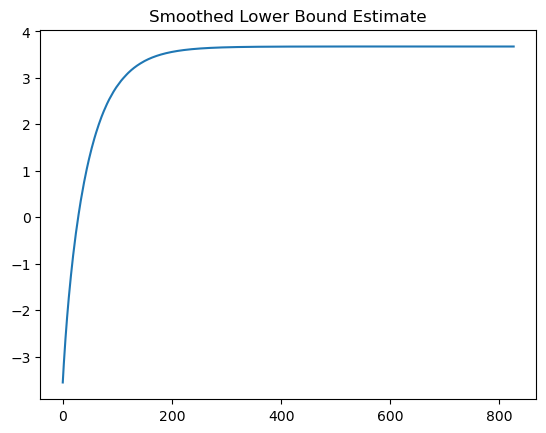

In [15]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

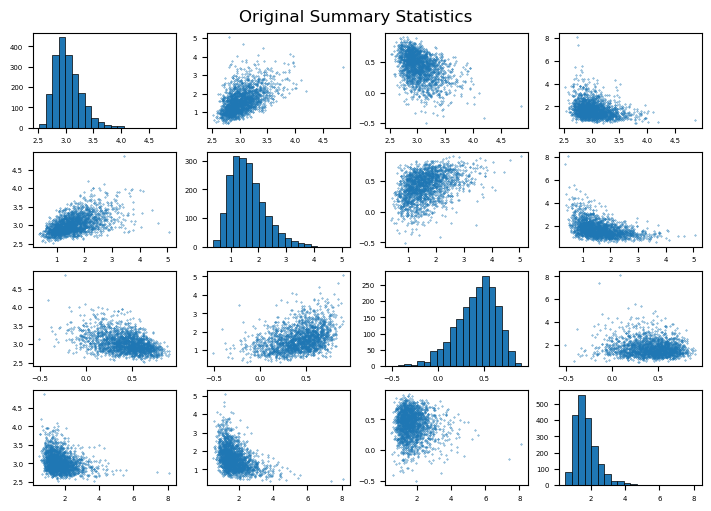

In [16]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x], original_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


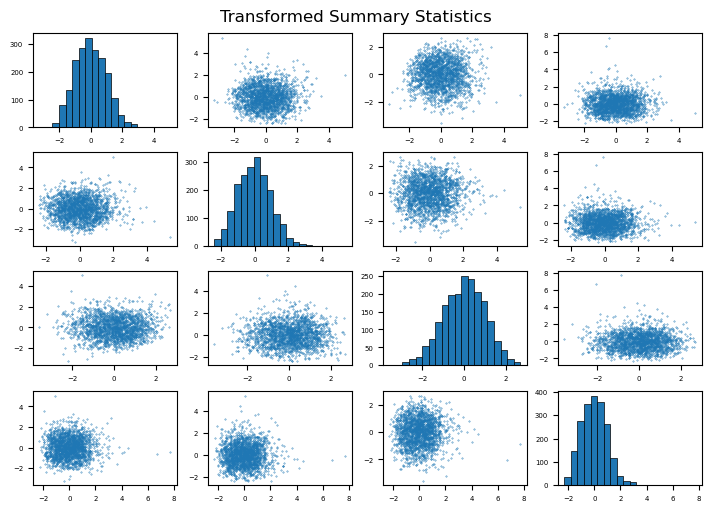

In [17]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x], wass_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

<Axes: >

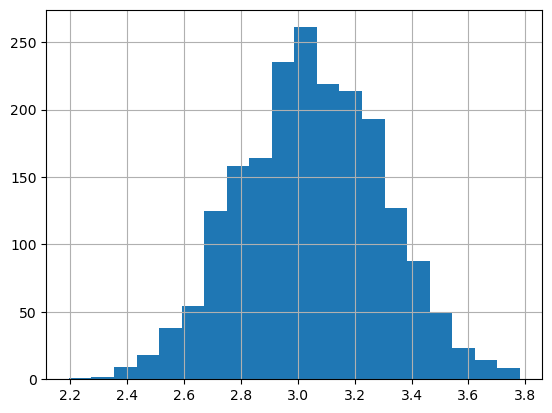

In [18]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 20)

In [19]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-300]
mixture_obj_seq

[GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=3

In [20]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        mean_mixture_obj = mixture_obj.means_
        sigma_mixture_obj = mixture_obj.covariances_
        weights_mixture_obj = mixture_obj.weights_
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

In [21]:
def summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    cov = np.cov(np.array(transformed_summary_statistics).T)
    sample_variance = cov + (np.eye(cov.shape[0]) * 5 * 1e-7)
    return sample_mean, sample_variance

In [22]:
def mean_adjustment_summary_statistics(adjusted_theta, mixture_obj_seq, num_samples, num_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = sample_mean + np.diag(scipy.linalg.sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [23]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

# def unbiased_log_likelihood(theta):
#     ss = summary_statistics(theta, num_samples, num_datasets)
#     sample_mean = ss[0]
#     sample_variance = ss[1]
#     # diff_mean_s = actual_summary_statistics - sample_mean
#     # part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
#     # # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
#     # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1

#     u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

#     return u_est_log_likelihood

def prior_gamma(gamma, sigma_latent, num_latent): 
    log_prior = multivariate_normal.logpdf(gamma, cov= sigma_latent * np.identity(num_latent))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, num_samples, num_datasets, actual_summary_statistics, mixture_obj_seq):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_variance = mean_adj_ss[1]

    # mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(sample_variance)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    part1 = (Gamma - mean_nuissance).T @ my_inv(variance_nuissance) @ (Gamma - mean_nuissance)
    nuissance_mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(variance_nuissance)[1] - part1
    # nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [24]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                rng = np.random.default_rng()
                theta_0_samples = rng.multivariate_normal(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = theta_tilde_0[0]
                    beta_0 = np.exp(theta_tilde_0[1])
                    gamma_0 = theta_tilde_0[2]
                    delta_0 = np.exp(theta_tilde_0[3])
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    ss_0 = summary_statistics(theta_0, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_variance_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_0)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_0) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_0) @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                rng = np.random.default_rng()
                theta_q_samples = rng.multivariate_normal(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    beta_q = np.exp(theta_tilde_q[1])
                    gamma_q = theta_tilde_q[2]
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    ss_q = summary_statistics(theta_q, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_variance_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_q)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_q) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

      
                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [25]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[2.96978227, 1.45609898, 0.4837584 , 2.00723605]])

In [26]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([-0.00631865, -0.03321667,  0.22897961,  0.56710931])

In [25]:
# Set hyperparameters
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [00:48<67:57:41, 48.94s/it]

LB -25.85768559605213


  0%|          | 2/5000 [01:39<69:35:35, 50.13s/it]

LB -22.91257873725345


  0%|          | 3/5000 [02:41<76:36:05, 55.19s/it]

LB -23.941230322998685


  0%|          | 4/5000 [03:32<74:17:30, 53.53s/it]

LB -23.114987060355578


  0%|          | 5/5000 [04:23<73:09:22, 52.73s/it]

LB -23.235210365959556


  0%|          | 6/5000 [05:15<73:04:10, 52.67s/it]

LB -20.835673362816607


  0%|          | 7/5000 [06:06<72:08:29, 52.01s/it]

LB -23.744577162537567


  0%|          | 8/5000 [06:57<71:34:27, 51.62s/it]

LB -24.073482172694426


  0%|          | 9/5000 [07:55<74:25:37, 53.68s/it]

LB -22.01626965682025


  0%|          | 10/5000 [08:51<75:23:59, 54.40s/it]

LB -22.48429297237324


  0%|          | 11/5000 [09:40<72:53:50, 52.60s/it]

LB -22.10732338804233


  0%|          | 12/5000 [10:29<71:31:47, 51.63s/it]

LB -22.956655904535474


  0%|          | 13/5000 [11:17<70:04:11, 50.58s/it]

LB -23.61532848189282


  0%|          | 14/5000 [12:08<70:09:29, 50.66s/it]

LB -21.3164691276785


  0%|          | 15/5000 [12:58<69:51:49, 50.45s/it]

LB -22.837618675344256


  0%|          | 16/5000 [13:47<69:04:13, 49.89s/it]

LB -22.824818768340496


  0%|          | 17/5000 [14:36<68:56:23, 49.81s/it]

LB -21.489716350775396


  0%|          | 18/5000 [15:26<68:49:17, 49.73s/it]

LB -22.853701976314834


  0%|          | 19/5000 [16:15<68:35:00, 49.57s/it]

LB -24.57117853444848


  0%|          | 20/5000 [17:06<68:59:05, 49.87s/it]

LB -22.705213074046288


  0%|          | 21/5000 [17:56<69:23:15, 50.17s/it]

LB -22.694319043924725


  0%|          | 22/5000 [18:46<69:00:03, 49.90s/it]

LB -22.919533461575906


  0%|          | 23/5000 [19:35<68:49:39, 49.78s/it]

LB -22.3586446258717


  0%|          | 24/5000 [20:24<68:24:52, 49.50s/it]

LB -22.045210506231214


  0%|          | 25/5000 [21:15<69:08:45, 50.04s/it]

LB -22.274437463097737


  1%|          | 26/5000 [22:05<68:47:09, 49.78s/it]

LB -21.241291438298695


  1%|          | 27/5000 [22:55<69:04:44, 50.01s/it]

LB -22.827491601433813


  1%|          | 28/5000 [23:43<68:24:22, 49.53s/it]

LB -21.889563994015184


  1%|          | 29/5000 [24:34<68:41:42, 49.75s/it]

LB -20.647129784471776


  1%|          | 30/5000 [25:24<68:51:37, 49.88s/it]

LB -22.334307631550136


  1%|          | 31/5000 [26:11<67:44:44, 49.08s/it]

LB -22.5924885020811


  1%|          | 32/5000 [27:01<68:16:09, 49.47s/it]

LB -23.83435077921711


  1%|          | 33/5000 [27:49<67:27:27, 48.89s/it]

LB -21.742545166361893


  1%|          | 34/5000 [28:35<66:04:17, 47.90s/it]

LB -22.44645944958893


  1%|          | 35/5000 [29:20<65:12:25, 47.28s/it]

LB -23.492725626125704


  1%|          | 36/5000 [30:06<64:38:05, 46.87s/it]

LB -22.50001834992685


  1%|          | 37/5000 [30:52<64:03:49, 46.47s/it]

LB -22.286124481711184


  1%|          | 38/5000 [31:39<64:11:30, 46.57s/it]

LB -21.828774783151584


  1%|          | 39/5000 [32:24<63:47:20, 46.29s/it]

LB -22.094905776529913


  1%|          | 40/5000 [33:10<63:34:00, 46.14s/it]

LB -21.82100970352836


  1%|          | 41/5000 [33:56<63:16:52, 45.94s/it]

LB -22.28412971576258


  1%|          | 42/5000 [34:41<62:57:50, 45.72s/it]

LB -21.486379059569586


  1%|          | 43/5000 [35:27<63:14:43, 45.93s/it]

LB -22.513367216357636


  1%|          | 44/5000 [36:13<63:05:56, 45.83s/it]

LB -21.714245254313855


  1%|          | 45/5000 [37:00<63:28:08, 46.11s/it]

LB -22.049288048659868


  1%|          | 46/5000 [37:46<63:28:44, 46.13s/it]

LB -21.60495992478595


  1%|          | 47/5000 [38:32<63:37:44, 46.25s/it]

LB -23.077757884566868


  1%|          | 48/5000 [39:21<64:49:09, 47.12s/it]

LB -21.72020347737761


  1%|          | 49/5000 [40:11<65:45:49, 47.82s/it]

LB -21.585951292848755


  1%|          | 50/5000 [41:01<66:52:47, 48.64s/it]

LB -21.80603830875145


  1%|          | 51/5000 [41:49<66:23:37, 48.30s/it]

LB Smoothed -22.435713845855425


  1%|          | 52/5000 [42:51<72:13:06, 52.54s/it]

LB Smoothed -22.431635275982366


  1%|          | 53/5000 [43:42<71:29:32, 52.03s/it]

LB Smoothed -22.40117154673512


  1%|          | 54/5000 [44:36<72:00:24, 52.41s/it]

LB Smoothed -22.3679081921119


  1%|          | 55/5000 [45:25<70:49:31, 51.56s/it]

LB Smoothed -22.346459688948393


  1%|          | 56/5000 [46:13<69:12:28, 50.39s/it]

LB Smoothed -22.366904813510054


  1%|          | 57/5000 [47:01<68:25:18, 49.83s/it]

LB Smoothed -22.33864089001329


  1%|          | 58/5000 [47:50<67:51:00, 49.43s/it]

LB Smoothed -22.300473406364382


  1%|          | 59/5000 [48:37<66:44:46, 48.63s/it]

LB Smoothed -22.32312469548619


  1%|          | 60/5000 [49:29<68:23:34, 49.84s/it]

LB Smoothed -22.32321522091139


  1%|          | 61/5000 [50:23<69:50:42, 50.91s/it]

LB Smoothed -22.340293110938216


  1%|          | 62/5000 [51:13<69:31:30, 50.69s/it]

LB Smoothed -22.304188032282926


  1%|▏         | 63/5000 [52:03<69:10:48, 50.45s/it]

LB Smoothed -22.265084337033624


  1%|▏         | 64/5000 [52:57<70:49:09, 51.65s/it]

LB Smoothed -22.27576744896786


  1%|▏         | 65/5000 [53:51<71:31:52, 52.18s/it]

LB Smoothed -22.256975375316152


  1%|▏         | 66/5000 [54:44<71:57:11, 52.50s/it]

LB Smoothed -22.219545237166187


  1%|▏         | 67/5000 [55:35<71:23:18, 52.10s/it]

LB Smoothed -22.23080284953095


  1%|▏         | 68/5000 [56:22<69:28:21, 50.71s/it]

LB Smoothed -22.209218585160546


  1%|▏         | 69/5000 [57:10<68:21:17, 49.90s/it]

LB Smoothed -22.156532217495503


  1%|▏         | 70/5000 [57:59<67:58:50, 49.64s/it]

LB Smoothed -22.128382799790632


  1%|▏         | 71/5000 [58:49<67:44:01, 49.47s/it]

LB Smoothed -22.092995975280505


  1%|▏         | 72/5000 [59:39<68:10:48, 49.81s/it]

LB Smoothed -22.080817424016978


  1%|▏         | 73/5000 [1:00:29<68:03:04, 49.72s/it]

LB Smoothed -22.055265160755944


  1%|▏         | 74/5000 [1:01:19<68:07:57, 49.79s/it]

LB Smoothed -22.04791106602859


  2%|▏         | 75/5000 [1:02:07<67:30:26, 49.35s/it]

LB Smoothed -22.03307609603456


  2%|▏         | 76/5000 [1:02:53<66:19:32, 48.49s/it]

LB Smoothed -22.03976422783688


  2%|▏         | 77/5000 [1:03:40<65:24:25, 47.83s/it]

LB Smoothed -22.024875316178914


  2%|▏         | 78/5000 [1:04:26<64:57:40, 47.51s/it]

LB Smoothed -22.037237418761926


  2%|▏         | 79/5000 [1:05:13<64:24:30, 47.12s/it]

LB Smoothed -22.057535488608053


  2%|▏         | 80/5000 [1:05:59<64:09:49, 46.95s/it]

LB Smoothed -22.04589781272989


  2%|▏         | 81/5000 [1:06:47<64:25:48, 47.15s/it]

LB Smoothed -22.01249487351406


  2%|▏         | 82/5000 [1:07:33<63:59:14, 46.84s/it]

LB Smoothed -21.95852318200758


  2%|▏         | 83/5000 [1:08:19<63:42:13, 46.64s/it]

LB Smoothed -21.939996634210985


  2%|▏         | 84/5000 [1:09:06<63:52:30, 46.78s/it]

LB Smoothed -21.898045784341228


  2%|▏         | 85/5000 [1:09:52<63:33:07, 46.55s/it]

LB Smoothed -21.839154395034367


  2%|▏         | 86/5000 [1:10:40<64:07:26, 46.98s/it]

LB Smoothed -21.80706250829244


  2%|▏         | 87/5000 [1:11:26<63:36:20, 46.61s/it]

LB Smoothed -21.795680368340797


  2%|▏         | 88/5000 [1:12:11<62:58:36, 46.16s/it]

LB Smoothed -21.795873854585682


  2%|▏         | 89/5000 [1:12:57<62:42:04, 45.96s/it]

LB Smoothed -21.7910348484329


  2%|▏         | 90/5000 [1:13:43<62:44:06, 46.00s/it]

LB Smoothed -21.77490495198848


  2%|▏         | 91/5000 [1:14:35<65:06:21, 47.75s/it]

LB Smoothed -21.757911870484772


  2%|▏         | 92/5000 [1:15:25<66:14:09, 48.58s/it]

LB Smoothed -21.767439794069908


  2%|▏         | 93/5000 [1:16:15<66:46:20, 48.99s/it]

LB Smoothed -21.736583652608886


  2%|▏         | 94/5000 [1:17:10<69:02:50, 50.67s/it]

LB Smoothed -21.739117798439445


  2%|▏         | 95/5000 [1:18:00<68:48:56, 50.51s/it]

LB Smoothed -21.719487998954584


  2%|▏         | 96/5000 [1:18:48<67:44:43, 49.73s/it]

LB Smoothed -21.69800667889658


  2%|▏         | 97/5000 [1:19:36<67:15:29, 49.38s/it]

LB Smoothed -21.661310523160353


  2%|▏         | 98/5000 [1:20:26<67:24:32, 49.50s/it]

LB Smoothed -21.666274317640184


  2%|▏         | 99/5000 [1:21:15<67:07:45, 49.31s/it]

LB Smoothed -21.665915310722948


  2%|▏         | 100/5000 [1:22:04<66:58:26, 49.21s/it]

LB Smoothed -21.665809140655075


  2%|▏         | 101/5000 [1:22:52<66:42:42, 49.02s/it]

LB Smoothed -21.63694271637032


  2%|▏         | 102/5000 [1:23:45<68:14:10, 50.15s/it]

LB Smoothed -21.61066018098713


  2%|▏         | 103/5000 [1:24:41<70:39:55, 51.95s/it]

LB Smoothed -21.610649457660198


  2%|▏         | 104/5000 [1:25:32<70:10:09, 51.60s/it]

LB Smoothed -21.59900959382326


  2%|▏         | 105/5000 [1:26:21<69:14:42, 50.93s/it]

LB Smoothed -21.573872375995162


  2%|▏         | 106/5000 [1:27:11<68:51:48, 50.66s/it]

LB Smoothed -21.541349009670583


  2%|▏         | 107/5000 [1:28:06<70:21:06, 51.76s/it]

LB Smoothed -21.517467778478284


  2%|▏         | 108/5000 [1:28:58<70:38:29, 51.98s/it]

LB Smoothed -21.46085488781015


  2%|▏         | 109/5000 [1:29:47<69:13:33, 50.95s/it]

LB Smoothed -21.432724358957042


  2%|▏         | 110/5000 [1:30:38<69:29:00, 51.15s/it]

LB Smoothed -21.391861097370136


  2%|▏         | 111/5000 [1:31:30<69:45:26, 51.37s/it]

LB Smoothed -21.38863019063426


  2%|▏         | 112/5000 [1:32:21<69:24:43, 51.12s/it]

LB Smoothed -21.368628960431113


  2%|▏         | 113/5000 [1:33:10<68:41:05, 50.60s/it]

LB Smoothed -21.35067227963068


  2%|▏         | 114/5000 [1:33:59<68:00:22, 50.11s/it]

LB Smoothed -21.31998203388864


  2%|▏         | 115/5000 [1:34:47<67:10:21, 49.50s/it]

LB Smoothed -21.31824471093984


  2%|▏         | 116/5000 [1:35:38<67:29:58, 49.75s/it]

LB Smoothed -21.301555770630245


  2%|▏         | 117/5000 [1:36:34<70:01:19, 51.62s/it]

LB Smoothed -21.302674538105723


  2%|▏         | 118/5000 [1:37:22<68:36:33, 50.59s/it]

LB Smoothed -21.305447061341283


  2%|▏         | 119/5000 [1:38:11<67:48:22, 50.01s/it]

LB Smoothed -21.31251116805529


  2%|▏         | 120/5000 [1:39:01<68:00:23, 50.17s/it]

LB Smoothed -21.31937662733652


  2%|▏         | 121/5000 [1:39:49<66:57:26, 49.40s/it]

LB Smoothed -21.296683988307255


  2%|▏         | 122/5000 [1:40:41<68:08:16, 50.29s/it]

LB Smoothed -21.31806923414685


  2%|▏         | 123/5000 [1:41:30<67:46:46, 50.03s/it]

LB Smoothed -21.327984359495986


  2%|▏         | 124/5000 [1:42:24<69:20:44, 51.20s/it]

LB Smoothed -21.326348360099594


  2%|▎         | 125/5000 [1:43:19<70:52:14, 52.34s/it]

LB Smoothed -21.2938569667857


  3%|▎         | 126/5000 [1:44:10<70:09:30, 51.82s/it]

LB Smoothed -21.26500089303231


  3%|▎         | 127/5000 [1:45:01<69:49:57, 51.59s/it]

LB Smoothed -21.258941959750157


  3%|▎         | 128/5000 [1:45:52<69:45:29, 51.55s/it]

LB Smoothed -21.233293502522216


  3%|▎         | 129/5000 [1:46:41<68:21:40, 50.52s/it]

LB Smoothed -21.219218456571657


  3%|▎         | 130/5000 [1:47:31<68:15:31, 50.46s/it]

LB Smoothed -21.219587179388995


  3%|▎         | 131/5000 [1:48:20<67:33:24, 49.95s/it]

LB Smoothed -21.214627331117132


  3%|▎         | 132/5000 [1:49:10<67:48:42, 50.15s/it]

LB Smoothed -21.22226339328956


  3%|▎         | 133/5000 [1:50:04<69:19:29, 51.28s/it]

LB Smoothed -21.242851032107914


  3%|▎         | 134/5000 [1:50:56<69:20:44, 51.30s/it]

LB Smoothed -21.25345489968375


  3%|▎         | 135/5000 [1:51:47<69:26:29, 51.39s/it]

LB Smoothed -21.266398720578568


  3%|▎         | 136/5000 [1:52:40<70:04:45, 51.87s/it]

LB Smoothed -21.27635467955855


  3%|▎         | 137/5000 [1:53:30<69:25:02, 51.39s/it]

LB Smoothed -21.25455456374887


  3%|▎         | 138/5000 [1:54:20<68:43:17, 50.88s/it]

LB Smoothed -21.246006647689303


  3%|▎         | 139/5000 [1:55:09<68:03:48, 50.41s/it]

LB Smoothed -21.250180312091363


  3%|▎         | 140/5000 [1:56:00<67:57:26, 50.34s/it]

LB Smoothed -21.267286712866085


  3%|▎         | 141/5000 [1:56:51<68:13:36, 50.55s/it]

LB Smoothed -21.235509191337872


  3%|▎         | 142/5000 [1:57:41<68:04:41, 50.45s/it]

LB Smoothed -21.219089310497623


  3%|▎         | 143/5000 [1:58:29<67:06:01, 49.73s/it]

LB Smoothed -21.19939888869546


  3%|▎         | 144/5000 [1:59:17<66:23:44, 49.22s/it]

LB Smoothed -21.20408630452043


  3%|▎         | 145/5000 [2:00:07<66:37:46, 49.41s/it]

LB Smoothed -21.216567276546265


  3%|▎         | 146/5000 [2:00:56<66:37:46, 49.42s/it]

LB Smoothed -21.196713236815363


  3%|▎         | 147/5000 [2:01:48<67:22:49, 49.98s/it]

LB Smoothed -21.167376217069414


  3%|▎         | 148/5000 [2:02:39<68:06:28, 50.53s/it]

LB Smoothed -21.17446344225379


  3%|▎         | 149/5000 [2:03:30<68:13:57, 50.64s/it]

LB Smoothed -21.164109235636563


  3%|▎         | 150/5000 [2:04:20<68:03:41, 50.52s/it]

LB Smoothed -21.170675742274565


  3%|▎         | 151/5000 [2:05:11<68:00:51, 50.50s/it]

LB Smoothed -21.198238648711385


  3%|▎         | 152/5000 [2:06:01<67:53:26, 50.41s/it]

LB Smoothed -21.193909290858773


  3%|▎         | 153/5000 [2:06:51<67:33:26, 50.18s/it]

LB Smoothed -21.177011224457583


  3%|▎         | 154/5000 [2:07:41<67:32:14, 50.17s/it]

LB Smoothed -21.193428724849518


  3%|▎         | 155/5000 [2:08:31<67:26:28, 50.11s/it]

LB Smoothed -21.186063129057686


  3%|▎         | 156/5000 [2:09:22<67:55:22, 50.48s/it]

LB Smoothed -21.20043884965833


  3%|▎         | 157/5000 [2:10:13<67:58:59, 50.53s/it]

LB Smoothed -21.210885592553986


  3%|▎         | 158/5000 [2:11:02<67:12:23, 49.97s/it]

LB Smoothed -21.1872526132016


<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

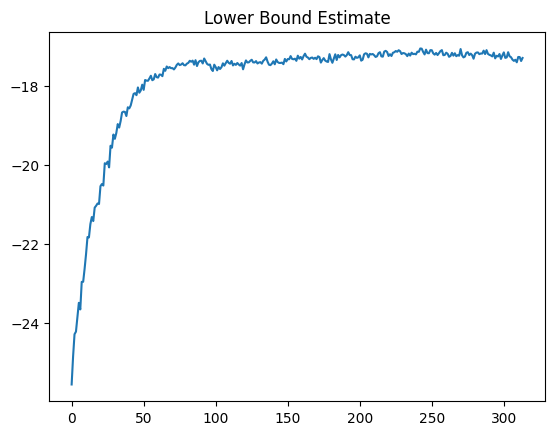

In [44]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

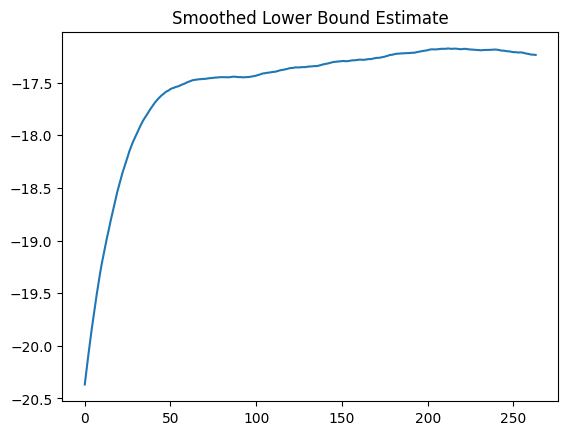

In [45]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [34]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 10000)
best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.21788474, 8.328837  , 1.21265657, 7.90678226])

Text(0.5, 1.0, 'Posterior density of alpha')

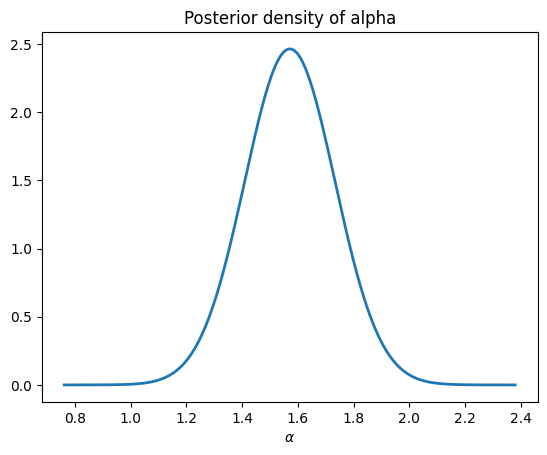

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

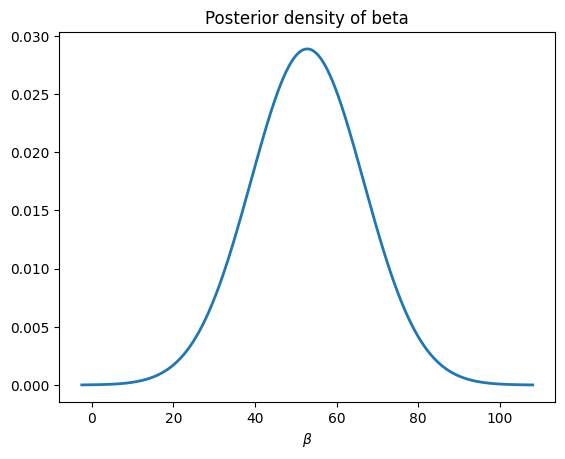

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

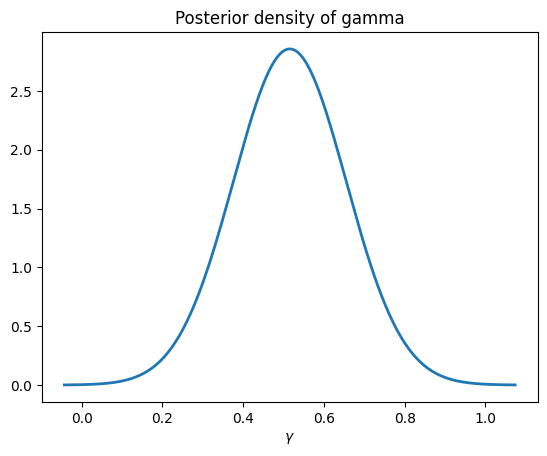

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 20000
num_burnin = 0.2 * num_samples
sigma_latent = 10

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0]-0)/(5-true_theta[0])), np.log((true_theta[1]-0)/(2-true_theta[1])), np.log((true_theta[2]-0)/(3-true_theta[2])), np.log((true_theta[3]-0)/(1-true_theta[3]))])

    alpha = theta_tilde[0]
    beta = np.exp(theta_tilde[1])
    gamma = theta_tilde[2]
    delta = np.exp(theta_tilde[3])

    theta = np.array([alpha, beta, gamma, delta])

    # GENERATE GAMMA
    ss = summary_statistics(theta, mixture_obj_seq, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]

    # Find mean and variance for p(gamma | theta, obs)

    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets, actual_summary_statistics)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = random.uniform(0, 1)
            if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))    
            else:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = theta_proposal_tilde[0]
        beta_prop = np.exp(theta_proposal_tilde[1])
        gamma_prop = theta_proposal_tilde[2]
        delta_prop = np.exp(theta_proposal_tilde[3])

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        # GENERATE GAMMA
        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]

        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, actual_summary_statistics)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)